In [61]:
import matplotlib.pyplot as plt
import importlib.util
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import random
import os

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
def redshift_to_snap(redshift):
    correspondense = {6:'sn013', 8:'sn008', 10:'sn004'}
    return correspondense[redshift]

In [3]:
def update_df(df, h=0.6774):
    #df.set_index('ID', inplace=True)
    df['Q0/HaloMass']=df['Q0']/df['HaloMass']
    df['R_v^3/HaloMass']=df['HaloRadii']**3/df['HaloMass']
    df['StarMass']= df['HaloMass']*df['FractionStars']
    return

In [4]:
def plot_num_comparison(comparison_df, x_prop='StarMass', all_runs=False, save=False):
    h=0.6774
    x_labelsize = 50
    y_labelsize = 50

    length_major_ticks = 16
    length_minor_ticks = 8
    width_minor_ticks = 3
    width_major_ticks = 4
    labelsize_x_ticks = 35
    labelsize_y_ticks = 35
    legendsize = 50

    markersize = 280
    colorbar_labelsize = 50
    colorbar_ticklabelsize = 35

    axes_width = 3

    figure_width = 20
    figure_height = 20

    if x_prop == 'HaloMass':
        x_label = 'Halo Mass [$\log(M_{\mathrm{sun}})$]'
        mult = 1e10/h
    elif x_prop == 'StarMass':
        x_label = 'Stellar Mass [$\log(M_{\mathrm{sun}})$]'
        mult=1.0

    y_label = '$f_\mathrm{esc}$'

    plt.scatter(np.log10(comparison_df[x_prop]*mult), comparison_df['f_esc_1e5'], label=r'$10^5$', marker='x', s=markersize)
    plt.scatter(np.log10(comparison_df[x_prop]*mult), comparison_df['f_esc_1e6'], label=r'$10^6$', marker='+', s=markersize)
    if all_runs:
        plt.scatter(np.log10(comparison_df[x_prop]*mult), comparison_df['f_esc_5e6'], label=r'$5 \times 10^6$', marker='1', s=markersize)
    plt.yscale('log')
    plt.legend(fontsize=legendsize)
    plt.rc('axes', linewidth=axes_width)
    plt.rc('xtick', labelsize=labelsize_x_ticks) 
    plt.rc('ytick', labelsize=labelsize_y_ticks) 
    plt.xlabel(x_label, size=x_labelsize)
    plt.ylabel(y_label, size=y_labelsize)
    if not all_runs:
        plt.ylim(1e-3,1.)

    plt.rcParams["figure.figsize"] = (figure_width,figure_height)
    plt.tight_layout(rect=(0,0,1,0.7))
    if save:
        if all_runs:
            filename = f'/u/ivkos/analysis/plots/{x_prop}_numerical_test_all.pdf'
        else:
            filename = f'/u/ivkos/analysis/plots/{x_prop}_numerical_test.pdf'
        plt.savefig(filename, bbox_inches = 'tight')
    plt.show();
    return

In [5]:
def get_scatter(df, halo_prop='StarMass', bins=30, mode='median', threshhold=1e-3, y_axis='f_esc'):
    
    x_values = df.loc[:,halo_prop]
    edges = np.logspace(np.log10(x_values.min()),np.log10(x_values.max()), bins)
    
    means = []
    quantile16 = []
    quantile84 = []
    error = []
    centers = []
    variance = []
    frac_small_arr = []
    
    for i in range(len(edges)-1):
        sub_fesc = df[(edges[i]*(1-1e-10)<df[halo_prop]) & (df[halo_prop]<edges[i+1])][y_axis]
        
        if mode == 'median':
            means.append(sub_fesc.median())
        elif mode == 'mean':
            means.append(sub_fesc.mean())
        centers.append(np.exp((np.log(edges[i+1])+np.log(edges[i]))/2.))
        quantile16.append(sub_fesc.quantile(0.16))
        quantile84.append(sub_fesc.quantile(0.84))
        error.append(sub_fesc.std()/np.sqrt(sub_fesc.shape[0]))
        variance.append(sub_fesc.var())
        frac_small_arr.append((sub_fesc < threshhold).sum()/len(sub_fesc))
        
    means = np.array(means)
    quantile16 = np.array(quantile16)
    quantile84= np.array(quantile84)
    error = np.array(error) 
    centers = np.array(centers)
    variance = np.array(variance)
    frac_small_arr = np.array(frac_small_arr)
        
    return centers, means, quantile16, quantile84, error, variance, frac_small_arr

In [6]:
def plot_tng_comparison(dfs, halo_id=None, halo_prop='StarMass', bins=30, mode='median', y_threshold=1e-3, save=False):
        
    redshifts = [6,8,10]
    
    linewidth = 6
    markersize = 260
    markersize_scat = 60

    upper_y_threshold = 1.
    lower_y_threshold_lin = 0.
    lower_y_threshold_log = y_threshold
    
    size_label = 50
    x_tick_major_size = 16
    x_tick_major_width = 4
    x_tick_minor_size = 8
    x_tick_minor_width = 3
    legend_fontsize = 35
    legend_loc = 'upper right'
    fig_width = 25
    fig_height = 20
    axes_width = 3
    tick_labelsize = 35
    
    results = {}
    results['tng'] = {}
    results['tng2'] = {} 
    results['tng3'] = {}
    
    if halo_prop == 'HaloMass':
        x_label = 'Halo Mass [$\log(M_{\mathrm{sun}})$]'
    elif halo_prop == 'StarMass':    
        x_label = 'Stellar Mass [$\log(M_{\mathrm{sun}})$]'
    else:
        raise ValueError("Only defined for the properties 'HaloMass' and 'StarMass'")
        
    y_axis = 'f_esc' 
    y_label = r'$\langle f_\mathrm{esc} \rangle$'
    var_label = '$\mathrm{var}(f_\mathrm{esc})$'
    low_esc_label = '$P(f_\mathrm{esc}<10^{-3})$'
    
    centers_tng, means_tng, *_ = get_scatter(dfs['tng'], halo_prop=halo_prop, bins=bins, 
                                               mode=mode, y_axis='f_esc')
    centers_tng2, means_tng2, *_ = get_scatter(dfs['tng2'], halo_prop=halo_prop, bins=bins, 
                                               mode=mode, y_axis='f_esc')
    centers_tng3, means_tng3, *_ = get_scatter(dfs['tng3'], halo_prop=halo_prop, bins=bins, 
                                               mode=mode, y_axis='f_esc')

    results['tng']['x'] = centers_tng
    results['tng']['y'] = means_tng

    results['tng2']['x'] = centers_tng2
    results['tng2']['y'] = means_tng2

    results['tng3']['x'] = centers_tng3
    results['tng3']['y'] = means_tng3
    
    f = plt.figure()
    ax1 = plt.subplot()

    x_values_dust = np.log10(results['tng']['x'])
    y_values_dust = results['tng']['y']
    #ax1.plot(x_values_dust, y_values_dust, linewidth=linewidth,  color='red', marker='+', label=r'dust')
    ax1.scatter(x_values_dust, y_values_dust, color='red', marker='+', s=markersize, label=r'TNG50')

    x_values_no_dust = np.log10(results['tng2']['x'])
    y_values_no_dust = results['tng2']['y']
    #ax1.plot(x_values_no_dust, y_values_no_dust, linewidth=linewidth,  color='blue', marker='x', linestyle='--', label=r'no dust')
    ax1.scatter(x_values_no_dust, y_values_no_dust, color='blue', marker='x', s=markersize, label=r'TNG50-2')
    
    x_values_no_dust = np.log10(results['tng3']['x'])
    y_values_no_dust = results['tng3']['y']
    #ax1.plot(x_values_no_dust, y_values_no_dust, linewidth=linewidth,  color='blue', marker='x', linestyle='--', label=r'no dust')
    ax1.scatter(x_values_no_dust, y_values_no_dust, color='green', marker='1', s=markersize, label=r'TNG50-3')
            
    ax1.set_yscale('log')
    ax1.set_ylim(lower_y_threshold_log, upper_y_threshold)
    ax1.set_ylabel(y_label, size=size_label)
    ax1.set_xlabel(x_label, size=size_label)
    ax1.tick_params(length=x_tick_major_size, width=x_tick_major_width)
    ax1.tick_params(length=x_tick_minor_size, width=x_tick_minor_width, which='minor')
    ax1.legend(fontsize=legend_fontsize, loc=legend_loc)

    plt.rcParams["figure.figsize"] = (fig_width, fig_height)
    plt.rc('axes', linewidth=axes_width)
    plt.rc('xtick', labelsize=tick_labelsize) 
    plt.rc('ytick', labelsize=tick_labelsize) 
    if save:
        path = f'/u/ivkos/analysis/plots/tng_comparison_{halo_prop}.pdf'
        plt.savefig(path, bbox_inches = 'tight')
    plt.show();
    return

In [64]:
def update_df(df, h=0.6774):
    df['StarMass']= df['HaloMass']*df['FractionStars']*1e10/h
    return

In [8]:
df_1e6_full = pd.read_pickle('dfs/new_numerical_1e6.pickle')
df_5e6 = pd.read_pickle('dfs/new_numerical_5e6.pickle')
df = pd.read_pickle('dfs/full_esc.pickle')

In [57]:
df_1e7 = pd.read_pickle('dfs/conv1e7.pickle')
df_5e7 = pd.read_pickle('dfs/conv5e7.pickle')
df_1e8 = pd.read_pickle('dfs/conv1e8.pickle')
df_1e9 = pd.read_pickle('dfs/conv1e9.pickle')
#df_escape_sources = pd.read_pickle('dfs/escape_test.pickle')
#df_all_sources = pd.read_pickle('dfs/all_sources.pickle')

In [126]:
df_1e8 = pd.read_pickle('dfs/conv1e8.pickle')
df_escape_sources = pd.read_pickle('dfs/escape_test.pickle')
df_all_sources = pd.read_pickle('dfs/all_sources.pickle')

In [71]:
merge_1 = df_1e7.merge(df_5e7[['ID', 'z', 'f_esc']], on=['ID', 'z'], suffixes=['_1e7', '_5e7'])
merge_2 = merge_1.merge(df_1e8[['ID', 'z', 'f_esc']], on=['ID', 'z'])
merge_2['f_esc_1e8'] = merge_2['f_esc']
merge_2.drop(columns='f_esc', inplace=True)
merge_3 = merge_2.merge(df_1e9[['ID', 'z', 'f_esc']], on=['ID', 'z'])
merge_3['f_esc_1e9'] = merge_3['f_esc']
merge_3.drop(columns='f_esc', inplace=True)

In [84]:
update_df(merge_2)

In [62]:
new_results = pd.read_pickle('dfs/esc_analysis.pickle')

In [65]:
update_df(new_results)

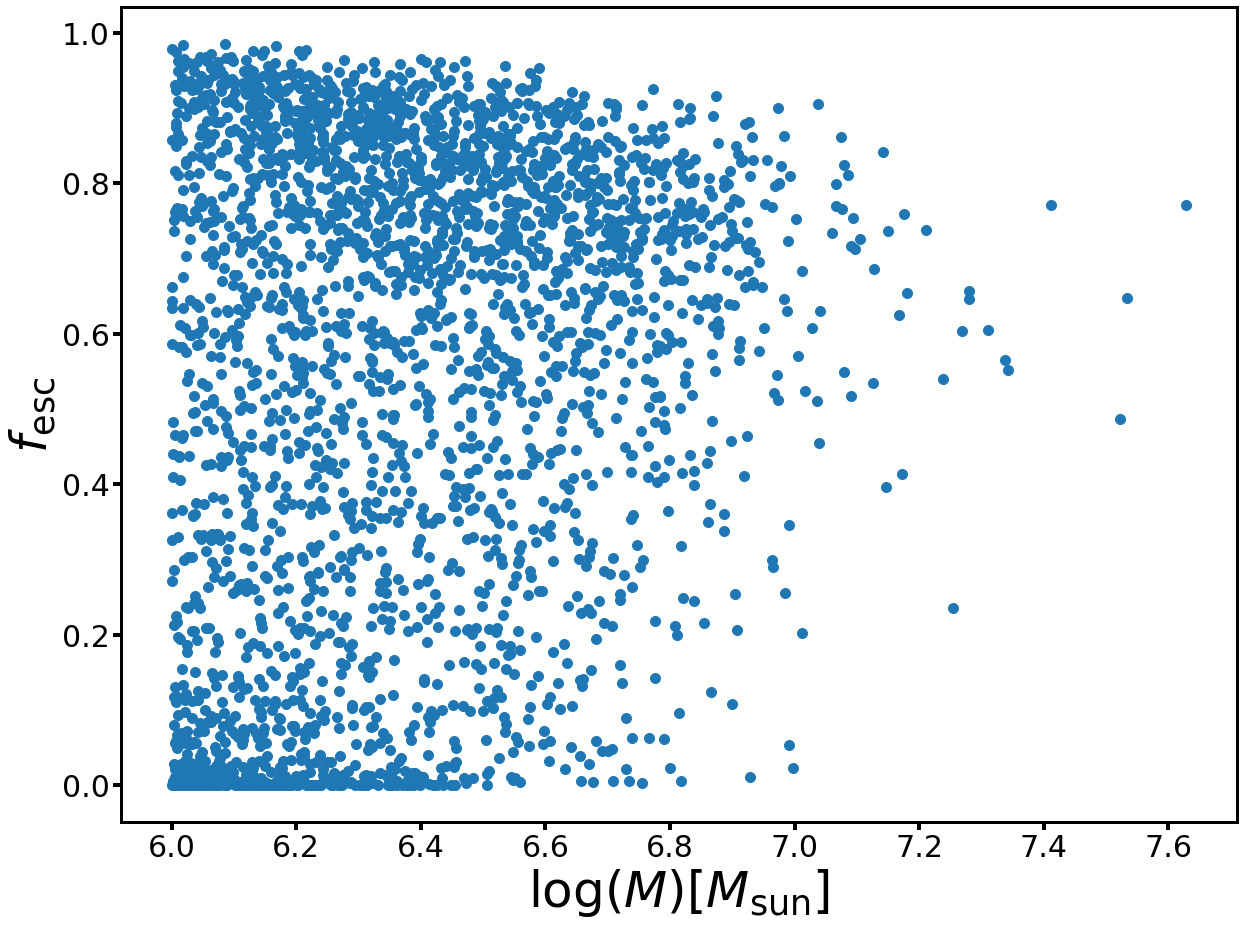

In [68]:
x_values = np.log10(new_results.StarMass)
y_values = new_results.f_esc
plt.scatter(x_values, y_values, marker='o', s=100)
#plt.scatter(x_values, y_values4, marker='o', s=100, label = r'1e9')
x_label = '$\log(M)[M_\mathrm{sun}]$'
y_label = r'$f_\mathrm{esc}$'
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
plt.xlabel(x_label, fontsize=50)
plt.ylabel(y_label, fontsize=50)
plt.rc('axes', linewidth=3)
plt.tick_params(length=8, width=4)
plt.tick_params(length=4, width=2, which='minor')
#plt.xlim(6,6.1)
plt.rcParams["figure.figsize"] = (20, 15);

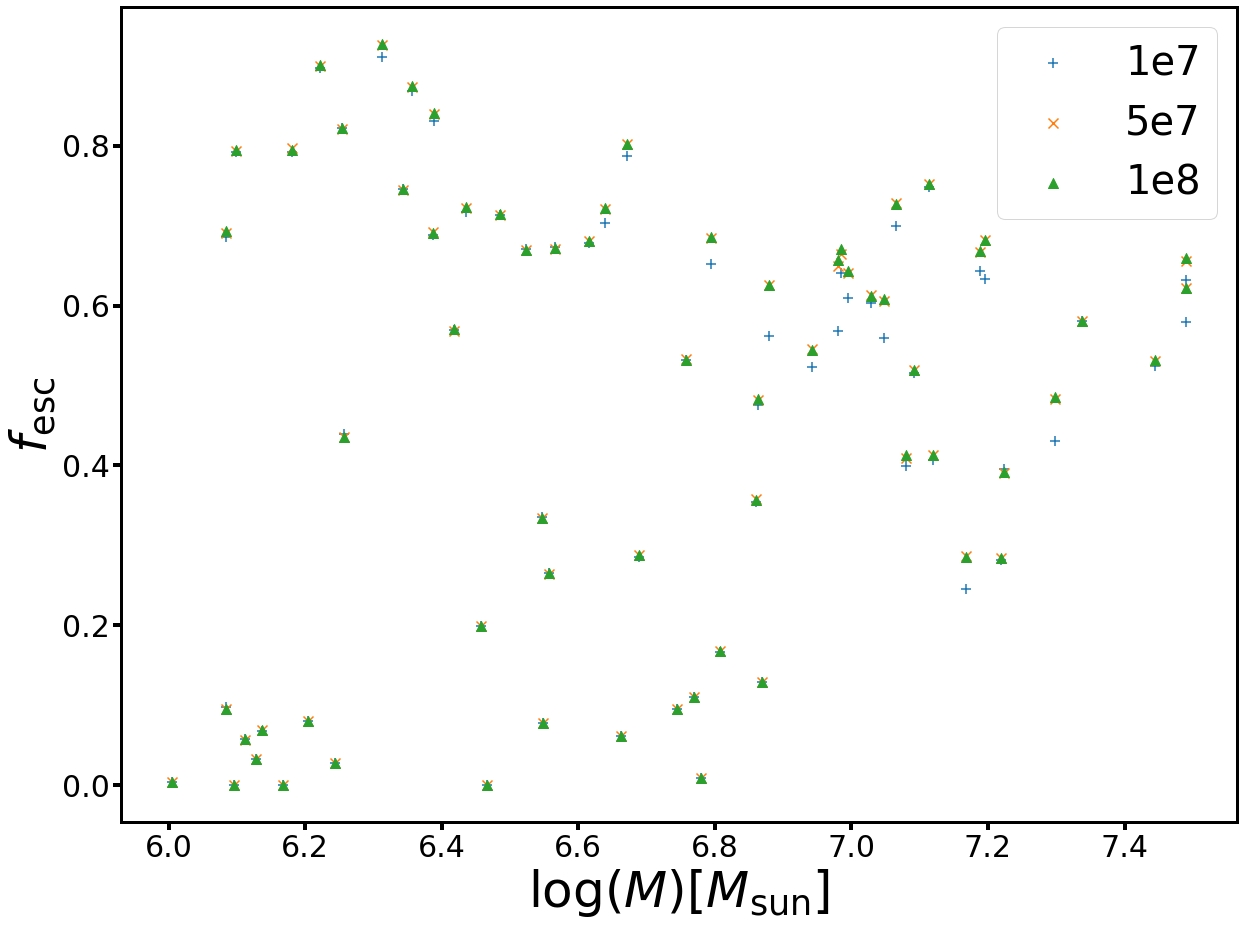

In [85]:
x_values = np.log10(merge_2.StarMass)

#y_values = (comparison_df2.f_esc_1e6-comparison_df2.f_esc_1e5)/comparison_df2.f_esc_1e5

y_values1 = merge_2.f_esc_1e7
y_values2 = merge_2.f_esc_5e7
y_values3 = merge_2.f_esc_1e8

plt.scatter(x_values, y_values1, marker='+', s=100, label = r'1e7')
plt.scatter(x_values, y_values2, marker='x', s=100, label = r'5e7')
plt.scatter(x_values, y_values3, marker='^', s=100, label = r'1e8')
#plt.scatter(x_values, y_values4, marker='o', s=100, label = r'1e9')
x_label = '$\log(M)[M_\mathrm{sun}]$'
y_label = r'$f_\mathrm{esc}$'
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
plt.xlabel(x_label, fontsize=50)
plt.ylabel(y_label, fontsize=50)
plt.rc('axes', linewidth=3)
plt.tick_params(length=8, width=4)
plt.tick_params(length=4, width=2, which='minor')
plt.legend(fontsize=40)
#plt.xlim(6,6.1)
plt.rcParams["figure.figsize"] = (20, 15);

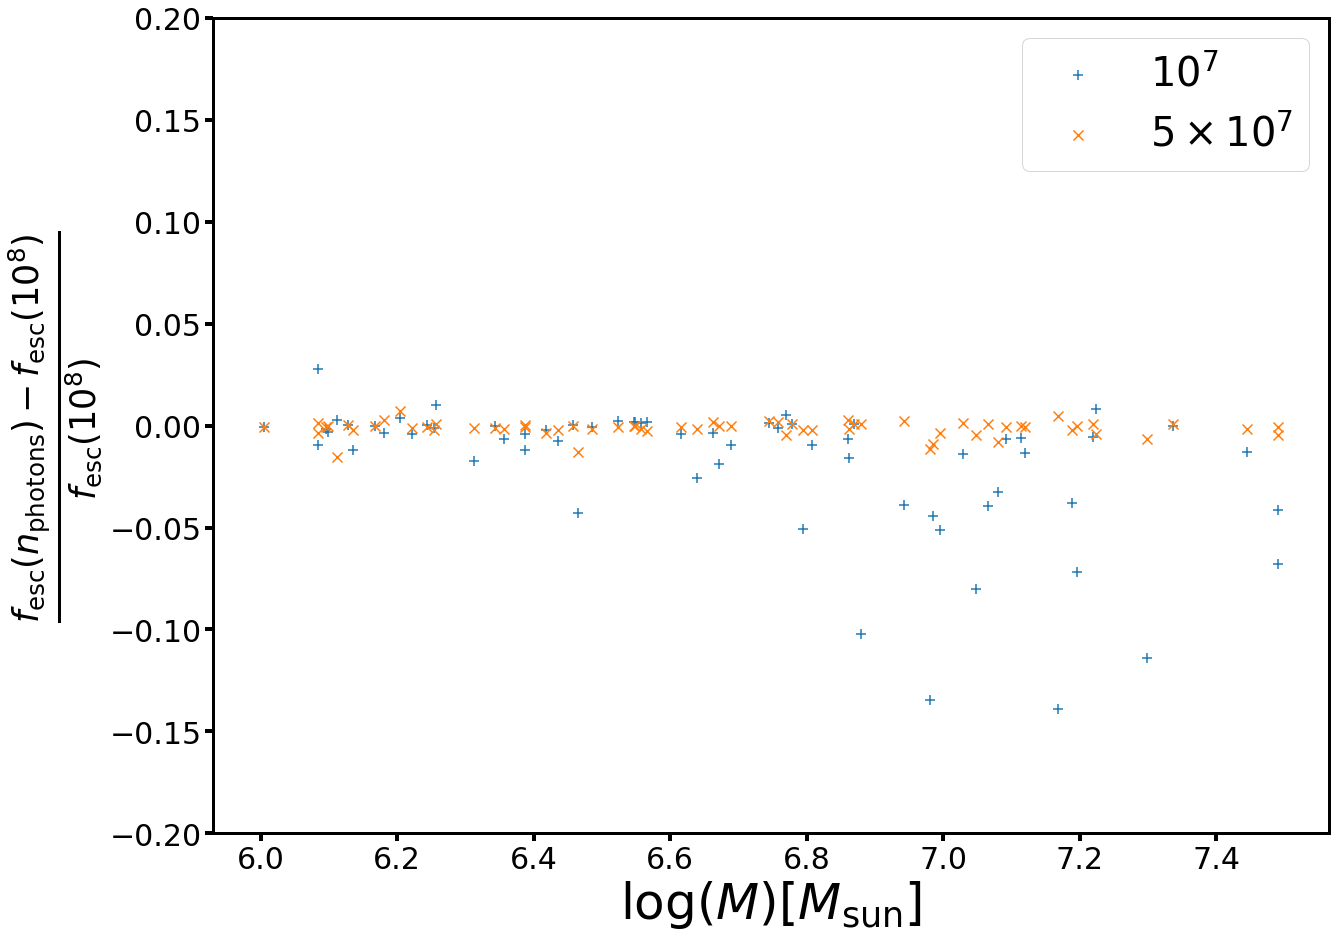

In [120]:
x_values = np.log10(merge_2.StarMass)

y_values1 = merge_2.f_esc_1e7
y_values2 = merge_2.f_esc_5e7
y_values3 = merge_2.f_esc_1e8
#y_values4 = merge_3.f_esc_1e9

plt.scatter(x_values, (y_values1-y_values3)/y_values3, marker='+', s=100, label='$10^7$')
plt.scatter(x_values, (y_values2-y_values3)/y_values3, marker='x', s=100, label=r'$5 \times 10^7$')

x_label = '$\log(M)[M_\mathrm{sun}]$'
y_label = r'$\frac{f_\mathrm{esc}(n_\mathrm{photons})-f_\mathrm{esc}(10^8)}{f_\mathrm{esc}(10^8)}$'
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
plt.xlabel(x_label, fontsize=50)
plt.ylabel(y_label, fontsize=50)
plt.rc('axes', linewidth=3)
plt.tick_params(length=8, width=4)
plt.tick_params(length=4, width=2, which='minor')
plt.ylim(-0.2,0.2)
plt.legend(fontsize=40)
#plt.xlim(6,6.1)
plt.rcParams["figure.figsize"] = (20, 15);

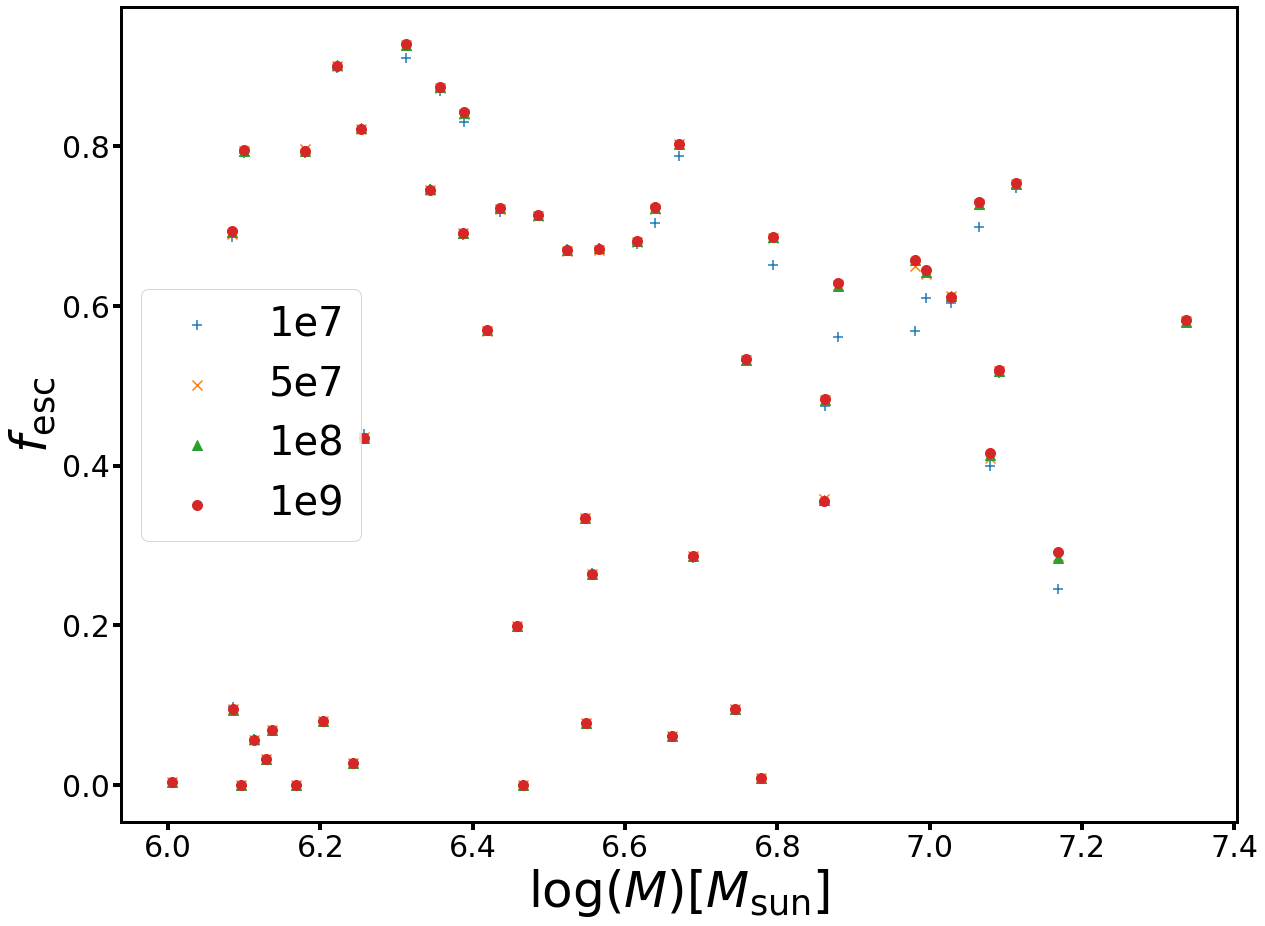

In [75]:
x_values = np.log10(merge_3.StarMass)

#y_values = (comparison_df2.f_esc_1e6-comparison_df2.f_esc_1e5)/comparison_df2.f_esc_1e5

y_values1 = merge_3.f_esc_1e7
y_values2 = merge_3.f_esc_5e7
y_values3 = merge_3.f_esc_1e8
y_values4 = merge_3.f_esc_1e9

plt.scatter(x_values, y_values1, marker='+', s=100, label = r'1e7')
plt.scatter(x_values, y_values2, marker='x', s=100, label = r'5e7')
plt.scatter(x_values, y_values3, marker='^', s=100, label = r'1e8')
plt.scatter(x_values, y_values4, marker='o', s=100, label = r'1e9')
x_label = '$\log(M)[M_\mathrm{sun}]$'
y_label = r'$f_\mathrm{esc}$'
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
plt.xlabel(x_label, fontsize=50)
plt.ylabel(y_label, fontsize=50)
plt.rc('axes', linewidth=3)
plt.tick_params(length=8, width=4)
plt.tick_params(length=4, width=2, which='minor')
plt.legend(fontsize=40)
#plt.xlim(6,6.1)
plt.rcParams["figure.figsize"] = (20, 15);

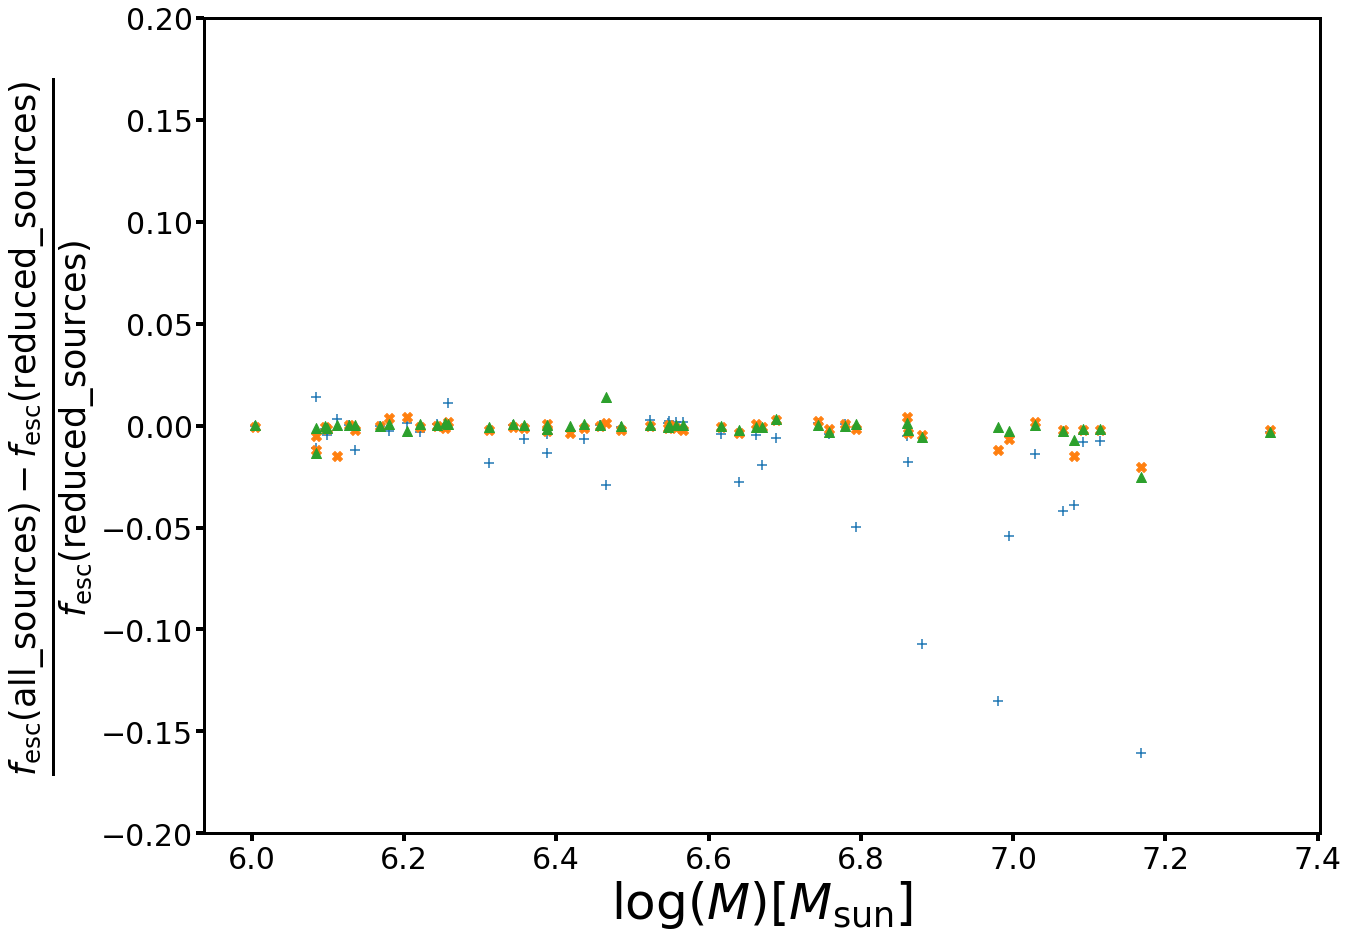

In [78]:
x_values = np.log10(merge_3.StarMass)

y_values1 = merge_3.f_esc_1e7
y_values2 = merge_3.f_esc_5e7
y_values3 = merge_3.f_esc_1e8
y_values4 = merge_3.f_esc_1e9

plt.scatter(x_values, (y_values1-y_values4)/y_values4, marker='+', s=100)
plt.scatter(x_values, (y_values2-y_values4)/y_values4, marker='X', s=100)
plt.scatter(x_values, (y_values3-y_values4)/y_values4, marker='^', s=100)
x_label = '$\log(M)[M_\mathrm{sun}]$'
y_label = r'$\frac{f_\mathrm{esc}(\mathrm{all\_sources})-f_\mathrm{esc}(\mathrm{reduced\_sources})}{f_\mathrm{esc}(\mathrm{reduced\_sources})}$'
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
plt.xlabel(x_label, fontsize=50)
plt.ylabel(y_label, fontsize=50)
plt.rc('axes', linewidth=3)
plt.tick_params(length=8, width=4)
plt.tick_params(length=4, width=2, which='minor')
plt.ylim(-0.2,0.2)
#plt.xlim(6,6.1)
plt.rcParams["figure.figsize"] = (20, 15);

In [102]:
std = np.array(merge_3[['f_esc_1e7', 'f_esc_5e7', 'f_esc_1e8', 'f_esc_1e9']].std())/np.sqrt(len(merge_3))
#percentile_84 = np.array(merge_3[['f_esc_1e7', 'f_esc_5e7', 'f_esc_1e8', 'f_esc_1e9']].quantile(0.84))
f_esc_means = np.array(merge_3[['f_esc_1e7', 'f_esc_5e7', 'f_esc_1e8', 'f_esc_1e9']].mean())

In [95]:
np.log10(5e7)

7.698970004336019

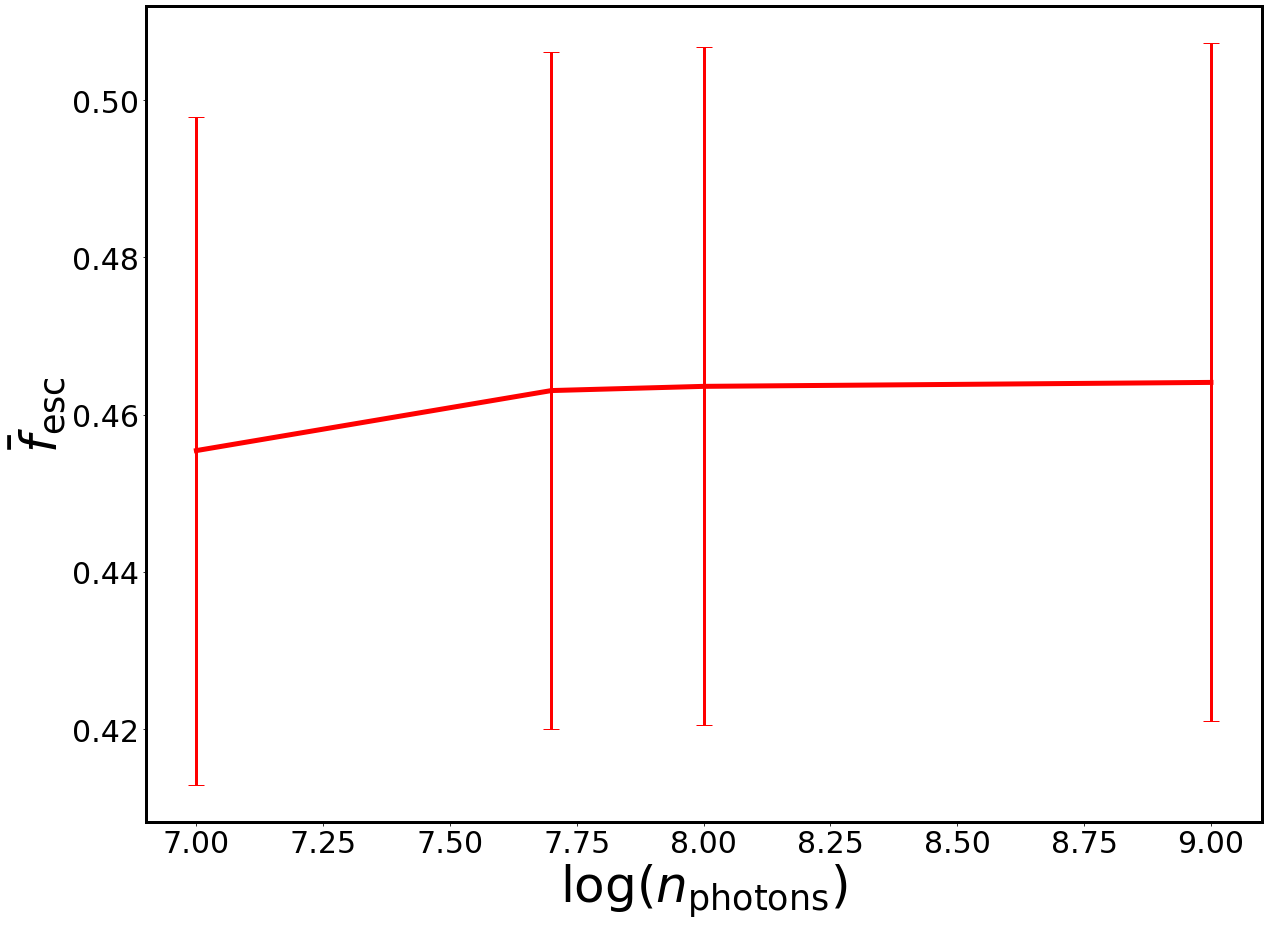

In [115]:
x_values = [7, 7.7, 8, 9]
plt.errorbar(x_values, f_esc_means, yerr=std, linewidth=5, elinewidth=3, color='red', capsize=8)
plt.xlabel(r'$\log(n_\mathrm{photons})$', size=50)
plt.ylabel(r'$\bar{f}_\mathrm{esc}$', size=50);

In [127]:
merge_all = df_1e8.merge(df_all_sources[['ID', 'z', 'f_esc']], on=['ID', 'z'], suffixes=['_1e8', '_all_sources'])
merge_escape_sources = merge_all.merge(df_escape_sources[['ID', 'z', 'f_esc']], on=['ID', 'z'])
merge_escape_sources['f_esc_esc_sources'] = merge_escape_sources['f_esc']

In [128]:
update_df(merge_escape_sources)

In [27]:
import h5py

In [30]:
def h5toDict(f):

    d = {}

    def visitor(name, node):
        if isinstance(node, h5py.Dataset):
            d[name] = np.array(node)
        return 
    
    f.visititems(visitor)

    # restore hierarchical structure as the visitor flattens it
    dd = {}
    for key, val in d.items():
        keys = key.split('/')
        ddd = dd
        for k in keys[:-1]:
            if k in ddd:
                ddd = ddd[k]
            else:
                ddd[k] = {}
                ddd = ddd[k]
        ddd[keys[-1]] = val

    return dd

In [67]:
path = '/ptmp/mpa/mglatzle/TNG_f_esc/conv1e8/run/L35n2160TNG/sn013/g3919/Output/f_esc_phys_ic00_rt05.hdf5'
with h5py.File(path,'r') as f:
    fesc = h5toDict(f)

In [68]:
fesc.keys()

dict_keys(['1.0e-4', '5.0e-2'])

In [42]:
path = '/ptmp/mpa/mglatzle/TNG_f_esc/full_esc/run/L35n2160TNG/sn013/g62846/Output/f_esc_phys_ic00_rt05.hdf5'
with h5py.File(path,'r') as f:
    fesc = h5toDict(f)

In [54]:
fesc.keys()

dict_keys(['1.0e-4'])

In [53]:
fesc['5.0e-2']['1.0e0']['n_iterations']

KeyError: '5.0e-2'

In [51]:
fesc['1.0e-4']['1.0e0']['n_iterations']

array(7)

In [131]:
merge_all = df_1e8.merge(all_sources[['ID', 'z', 'f_esc']], on=['ID', 'z'], suffixes=['_1e8', '_all_sources'])

In [9]:
merge_1 = df.merge(df_5e6[['ID', 'z', 'f_esc']], on=['ID', 'z'], suffixes=['_1e5', '_5e6'])
comparison_df = merge_1.merge(df_1e6_full[['ID', 'z', 'f_esc']], on=['ID', 'z'])
comparison_df['f_esc_1e6'] = comparison_df['f_esc']
update_df(comparison_df)

In [88]:
comparison_df2 = df.merge(df_1e6_full[['ID', 'z', 'f_esc', 'per_freq']], on=['ID', 'z'], suffixes=['_1e5', '_1e6'])
update_df(comparison_df2)

In [89]:
comparison_df3 = df.merge(df_5e6[['ID', 'z', 'f_esc', 'per_freq']], on=['ID', 'z'], suffixes=['_1e5', '_5e6'])
update_df(comparison_df3)

In [39]:
df_tng2 = pd.read_pickle('dfs/TNG50_2.pickle')
update_df(df_tng2)
df_tng3 = pd.read_pickle('dfs/TNG50_3.pickle')
update_df(df_tng3)
update_df(df)

In [40]:
dfs = {}
dfs['tng'] = df
dfs['tng2'] = df_tng2
dfs['tng3'] = df_tng3

In [ ]:
def get_scatter(df, halo_prop='StarMass', bins=30, mode='median', threshhold=1e-3, y_axis='f_esc'):
    
    x_values = df.loc[:,halo_prop]
    edges = np.logspace(np.log10(x_values.min()),np.log10(x_values.max()), bins)
    
    means = []
    quantile16 = []
    quantile84 = []
    error = []
    centers = []
    variance = []
    frac_small_arr = []
    
    for i in range(len(edges)-1):
        sub_fesc = df[(edges[i]*(1-1e-10)<df[halo_prop]) & (df[halo_prop]<edges[i+1])][y_axis]
        
        means.append(sub_fesc.mean())
        centers.append(np.exp((np.log(edges[i+1])+np.log(edges[i]))/2.))
        quantile16.append(sub_fesc.quantile(0.16))
        quantile84.append(sub_fesc.quantile(0.84))
        error.append(sub_fesc.std()/np.sqrt(sub_fesc.shape[0]))
        variance.append(sub_fesc.var())
        frac_small_arr.append((sub_fesc < threshhold).sum()/len(sub_fesc))
        
    means = np.array(means)
    quantile16 = np.array(quantile16)
    quantile84= np.array(quantile84)
    error = np.array(error) 
    centers = np.array(centers)
    variance = np.array(variance)
    frac_small_arr = np.array(frac_small_arr)
        
    return centers, means, quantile16, quantile84, error, variance, frac_small_arr

In [ ]:
def plot_scatter(df, halo_prop='StarMass', bins=30, mode='median', threshold=1e-3, 
                 include_frac=False, save=False, lin=False, galaxy=False, include_galaxy=False):
        
    redshifts = [6,8,10]
    mult = 1e10/h
    
    linewidth = 8
    quantile_alpha = 0.3
    upper_y_threshold = 1.
    lower_y_threshold_lin = 0.
    size_label = 50
    x_tick_major_size = 16
    x_tick_major_width = 4
    x_tick_minor_size = 8
    x_tick_minor_width = 3
    legend_fontsize = 35
    legend_loc = 'upper right'
    fig_width = 20
    fig_height = 25
    axes_width = 3
    tick_labelsize = 35

    if halo_prop == 'HaloMass':
        x_label = 'Halo Mass [$\log(M_{\mathrm{sun}})$]'
    elif halo_prop == 'StarMass':    
        x_label = 'Stellar Mass [$\log(M_{\mathrm{sun}})$]'
    else:
        raise ValueError("Only defined for the properties 'HaloMass' and 'StarMass'")
        
    if galaxy:
        y_axis = 'f_esc_0_2' 
        y_label = '$f_\mathrm{esc, gal}$'
        var_label = '$\mathrm{var}(f_\mathrm{esc, gal})$'
        low_esc_label = '$P(f_\mathrm{esc, gal}<10^{-3})$'
    else:
        y_axis = 'f_esc' 
        median_label = r'$\langle f_\mathrm{esc} \rangle $'
        median_gal_label = r'$\langle f_\mathrm{esc, gal} \rangle $'
        y_label = '$f_\mathrm{esc}$'
        var_label = '$\mathrm{var}(f_\mathrm{esc})$'
        low_esc_label = '$P(f_\mathrm{esc}<10^{-3})$'
    
    centers, means, quantile16, quantile84, error, variance, frac_small_arr = get_scatter(df, halo_prop=halo_prop, 
                                                                                          bins=bins, mode=mode, y_axis=y_axis)
    
    if include_galaxy:
        _, means_gal, *_ = get_scatter(df, halo_prop=halo_prop, bins=bins, mode=mode, y_axis='f_esc_0_2')

    f_esc = np.array(df[y_axis])
    frac_small, f_esc_plot = place_fesc(f_esc, threshold)
    
    f = plt.figure()
    plt.subplots_adjust(hspace=0.001)

    ax1 = plt.subplot2grid((4 ,1), (0,0), rowspan=2)
    for z in redshifts:
        sub_df = df[df.z==z]
        x_ax_val = np.array(sub_df[halo_prop])
        _, y_ax_val =  place_fesc(np.array(sub_df[y_axis]), threshold)
        ax1.scatter(np.log10(x_ax_val*mult), y_ax_val, label=f'z={z}', zorder=-15)
    x_bins = np.log10(centers*mult)
    ax1.plot(x_bins, means, linewidth=linewidth,  color='red', label=median_label)
    if include_galaxy:
        ax1.plot(x_bins, means_gal, linewidth=linewidth,  color='blue', linestyle='--', label=median_gal_label)
    ax1.fill_between(x_bins, quantile16, quantile84, color='red', alpha=quantile_alpha)
    #ax1.errorbar(np.log10(centers*mult), means, yerr=error, linewidth=4, elinewidth=2, capsize=10, color='red', label=r'$\langle f_\mathrm{esc} \rangle$')
    if lin:
        ax1.set_ylim(lower_y_threshold_lin, upper_y_threshold)
    else:
        ax1.set_yscale('log')
        ax1.set_ylim(threshold, upper_y_threshold)
    ax1.set_ylabel(y_label, size=size_label)
    ax1.tick_params(length=x_tick_major_size, width=x_tick_major_width)
    ax1.tick_params(length=x_tick_minor_size, width=x_tick_minor_width, which='minor')
    ax1.legend(fontsize=legend_fontsize, loc=legend_loc)
    ax1.set_rasterization_zorder(-15)
    
    ax2 = plt.subplot2grid((4,1), (2,0), sharex=ax1)
    ax2.plot(np.log10(centers*mult), variance, linewidth=linewidth)
    ax2.set_ylabel(var_label, size=size_label)
    ax2.set_xlabel(x_label, size=size_label)
    ax2.set_yscale('log')
    ax2.set_ylim(1e-4,1e-1)
    ax2.tick_params(length=x_tick_major_size, width=x_tick_major_width)
    ax2.tick_params(length=x_tick_minor_size, width=x_tick_minor_width, which='minor')
    
    if include_frac:
        ax3 = plt.subplot2grid((4,1), (3,0), sharex=ax2)
        ax3.plot(np.log10(centers*mult), frac_small_arr, linewidth=linewidth)
        ax3.set_ylabel(low_esc_label, size=size_label)
        ax3.set_xlabel(x_label, size=size_label)
        ax3.tick_params(length=x_tick_major_size, width=x_tick_major_width)
        ax3.tick_params(length=x_tick_minor_size, width=x_tick_minor_width, which='minor')

    #xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels()
    #plt.setp(xticklabels, visible=True)
    plt.rcParams["figure.figsize"] = (fig_width, fig_height)
    plt.rc('axes', linewidth=axes_width)
    plt.rc('xtick', labelsize=tick_labelsize) 
    plt.rc('ytick', labelsize=tick_labelsize) 
    if save:
        if lin:
            path = f'/u/ivkos/analysis/plots/{halo_prop}_fesc_lin.pdf'
        else:
            if galaxy:
                path = f'/u/ivkos/analysis/plots/{halo_prop}_fesc_galaxy.pdf'
            else:
                path = f'/u/ivkos/analysis/plots/{halo_prop}_fesc.pdf'
        plt.savefig(path, bbox_inches = 'tight')
    plt.show();
    return

In [44]:
df_1e4_full = pd.read_pickle('dfs/numerical_1e4.pickle')
df_1e5_full = pd.read_pickle('dfs/fid2.pickle')
df_1e6 = pd.read_pickle('dfs/numerical_1e6.pickle')
merge_1 = df_1e5_full.merge(df_1e6[['ID', 'z', 'f_esc']], on=['ID', 'z'], suffixes=['_1e5', '_1e6'])
comparison_df = merge_1.merge(df_1e4_full[['ID', 'z', 'f_esc']], on=['ID', 'z'])
comparison_df['f_esc_1e4'] = comparison_df['f_esc']
update_df(comparison_df)
del df_1e4_full
del df_1e5_full
del df_1e6

In [126]:
all_sources = pd.read_pickle('dfs/all_sources.pickle')

In [127]:
update_df(all_sources)

In [132]:
update_df(merge_all)

In [116]:
update_df(merge_1)
update_df(df_1e8)
update_df(df_1e9)

In [124]:
x_values1 = np.log10(merge_all.StarMass)
#y_values = (comparison_df2.f_esc_1e6-comparison_df2.f_esc_1e5)/comparison_df2.f_esc_1e5
y_values1 = merge_all.f_esc_1e8
y_values2 = merge_all.f_esc_all_sources

plt.scatter(x_values1, (y_values2-y_values1)/y_values1, marker='+', s=300)
x_label = '$\log(M)[M_\mathrm{sun}]$'
y_label = r'$\frac{f_\mathrm{esc}(\mathrm{all\_sources})-f_\mathrm{esc}(\mathrm{reduced\_sources})}{f_\mathrm{esc}(\mathrm{reduced\_sources})}$'
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
plt.xlabel(x_label, fontsize=50)
plt.ylabel(y_label, fontsize=50)
plt.rc('axes', linewidth=3)
plt.tick_params(length=8, width=4)
plt.tick_params(length=4, width=2, which='minor')
plt.ylim(-0.5,0.5)
#plt.xlim(6,6.1)
plt.rcParams["figure.figsize"] = (20, 15)

AttributeError: 'DataFrame' object has no attribute 'StarMass'

In [38]:
update_df(merge_escape_sources)

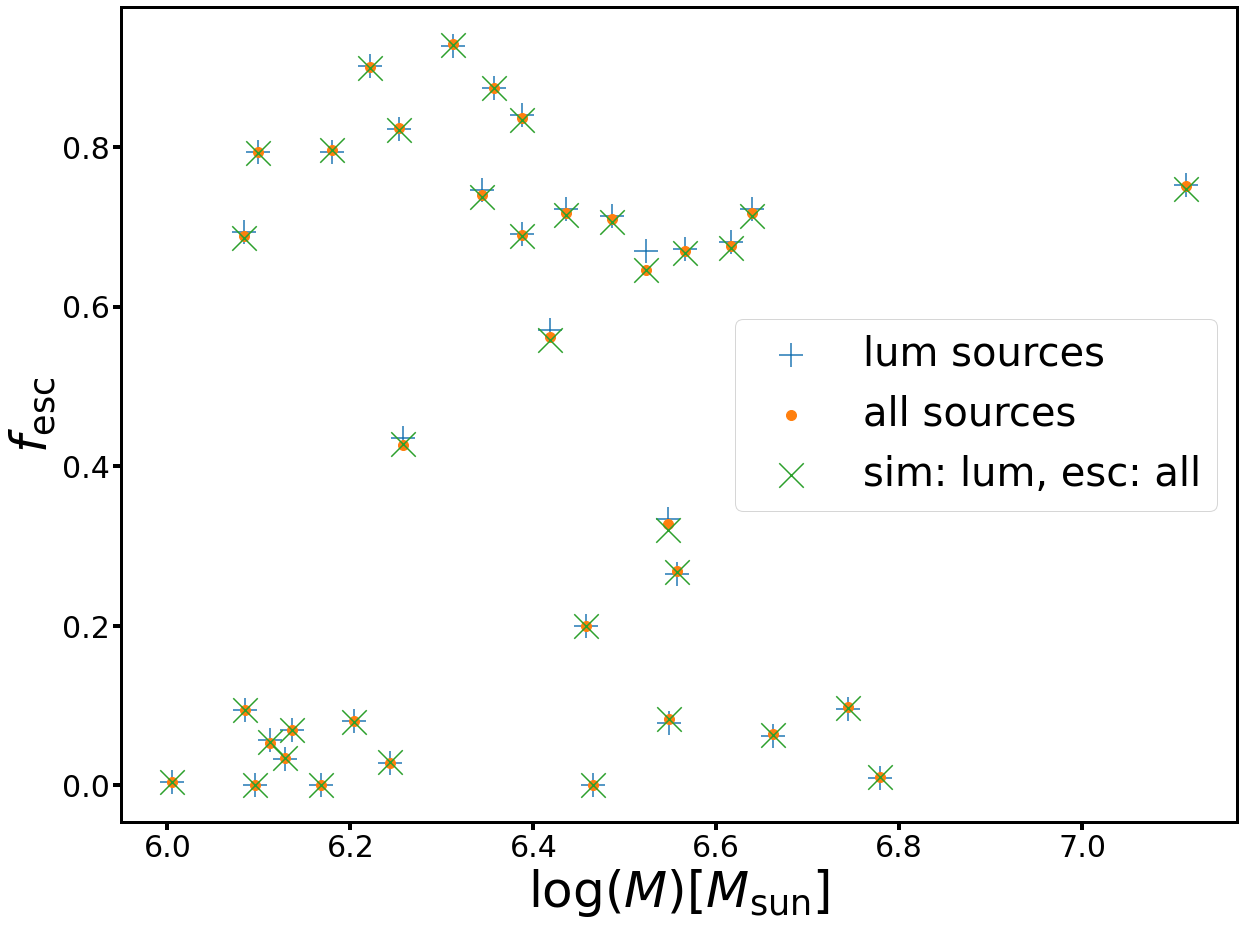

In [129]:
x_values = np.log10(merge_escape_sources.StarMass)

#y_values = (comparison_df2.f_esc_1e6-comparison_df2.f_esc_1e5)/comparison_df2.f_esc_1e5

y_values1 = merge_escape_sources.f_esc_1e8
y_values2 = merge_escape_sources.f_esc_all_sources
y_values3 = merge_escape_sources.f_esc_esc_sources

plt.scatter(x_values, y_values1, marker='+', s=600, label = r'lum sources')
plt.scatter(x_values, y_values2, marker='o', s=100, label = r'all sources')
plt.scatter(x_values, y_values3, marker='x', s=600, label = r'sim: lum, esc: all')
x_label = '$\log(M)[M_\mathrm{sun}]$'
y_label = r'$f_\mathrm{esc}$'
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
plt.xlabel(x_label, fontsize=50)
plt.ylabel(y_label, fontsize=50)
plt.rc('axes', linewidth=3)
plt.tick_params(length=8, width=4)
plt.tick_params(length=4, width=2, which='minor')
plt.legend(fontsize=40)
#plt.xlim(6,6.1)
plt.rcParams["figure.figsize"] = (20, 15);

In [134]:
merge_escape_sources.to_pickle('dfs/merge_escape_source.pickle')

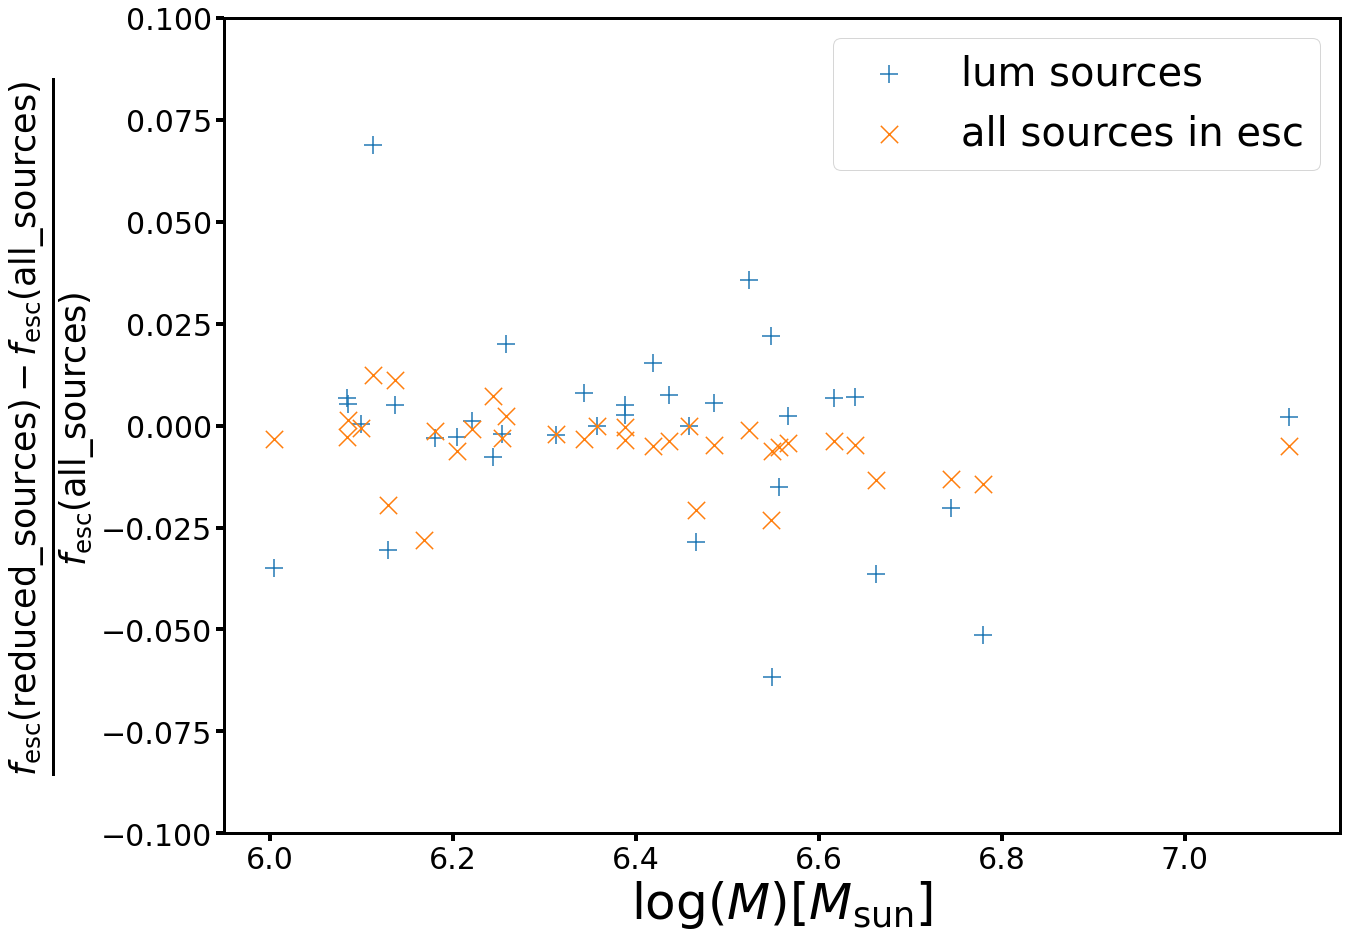

In [131]:
x_values = np.log10(merge_escape_sources.StarMass)

#y_values = (comparison_df2.f_esc_1e6-comparison_df2.f_esc_1e5)/comparison_df2.f_esc_1e5

y_values1 = merge_escape_sources.f_esc_1e8
y_values2 = merge_escape_sources.f_esc_all_sources
y_values3 = merge_escape_sources.f_esc_esc_sources

plt.scatter(x_values, (y_values1-y_values2)/y_values2, marker='+', s=300, label='lum sources')
plt.scatter(x_values, (y_values3-y_values2)/y_values2, marker='x', s=300, label='all sources in esc')
x_label = '$\log(M)[M_\mathrm{sun}]$'
y_label = r'$\frac{f_\mathrm{esc}(\mathrm{reduced\_sources})-f_\mathrm{esc}(\mathrm{all\_sources})}{f_\mathrm{esc}(\mathrm{all\_sources})}$'
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
plt.xlabel(x_label, fontsize=50)
plt.ylabel(y_label, fontsize=50)
plt.rc('axes', linewidth=3)
plt.tick_params(length=8, width=4)
plt.tick_params(length=4, width=2, which='minor')
plt.ylim(-0.1,0.1)
plt.legend(fontsize=40)
#plt.xlim(6,6.1)
plt.rcParams["figure.figsize"] = (20, 15);

Text(0.5, 0, '$\\log(M)[M_\\mathrm{sun}]$')

Text(0, 0.5, '$f_\\mathrm{esc}$')

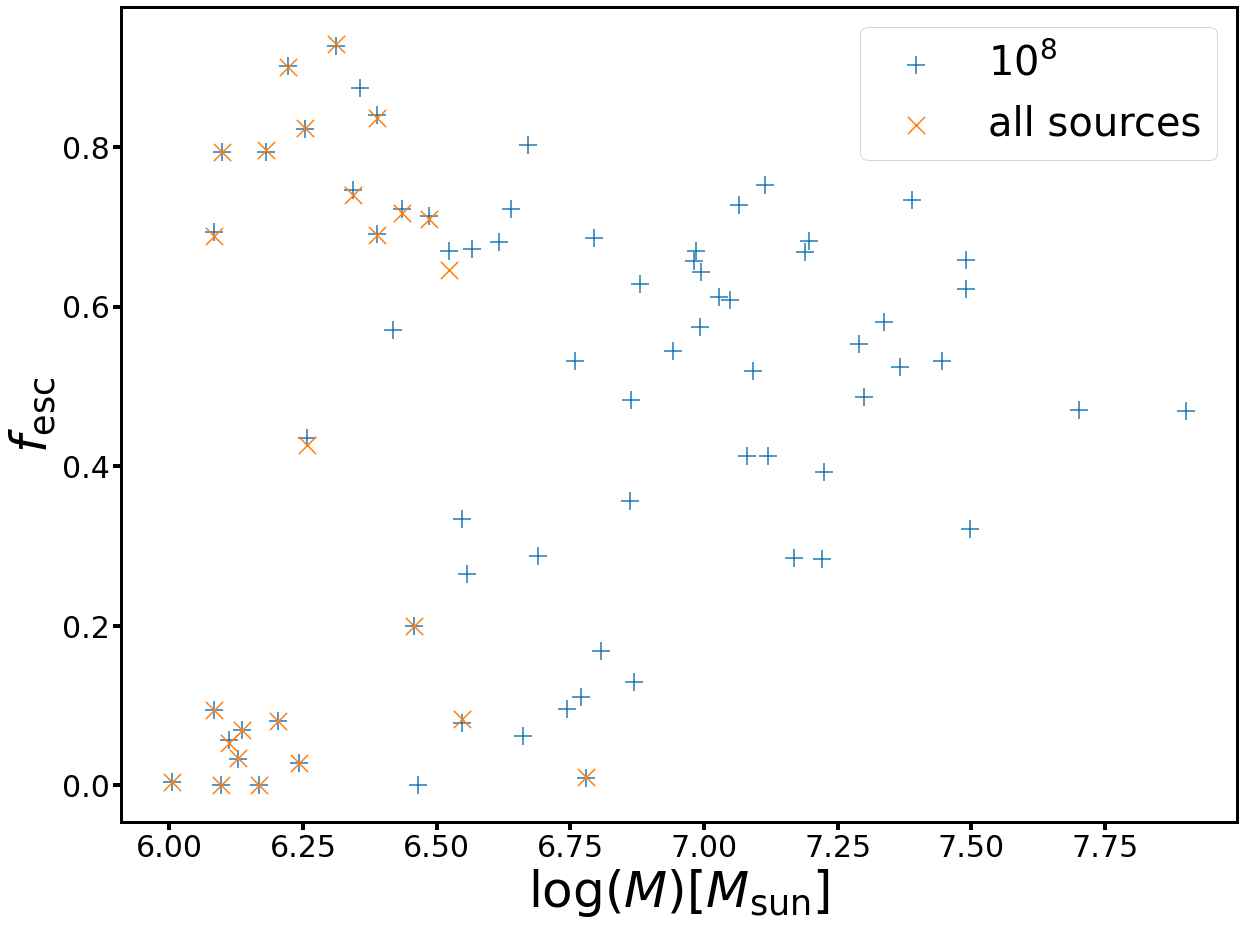

In [129]:
x_values1 = np.log10(df_1e8.StarMass)
x_values2 = np.log10(df_1e9.StarMass)
x_values3 = np.log10(all_sources.StarMass)
#y_values = (comparison_df2.f_esc_1e6-comparison_df2.f_esc_1e5)/comparison_df2.f_esc_1e5
y_values1 = df_1e8.f_esc
y_values2 = df_1e9.f_esc
y_values3 = all_sources.f_esc

plt.scatter(x_values1, y_values1, marker='+', s=300, label = r'$10^8$')
#plt.scatter(x_values2, y_values2, marker='x', s=300, label = r'$10^9$')
plt.scatter(x_values3, y_values3, marker='x', s=300, label = r'all sources')
x_label = '$\log(M)[M_\mathrm{sun}]$'
y_label = r'$f_\mathrm{esc}$'
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
plt.xlabel(x_label, fontsize=50)
plt.ylabel(y_label, fontsize=50)
plt.rc('axes', linewidth=3)
plt.tick_params(length=8, width=4)
plt.tick_params(length=4, width=2, which='minor')
plt.legend(fontsize=40)
#plt.xlim(6,6.1)
plt.rcParams["figure.figsize"] = (20, 15)

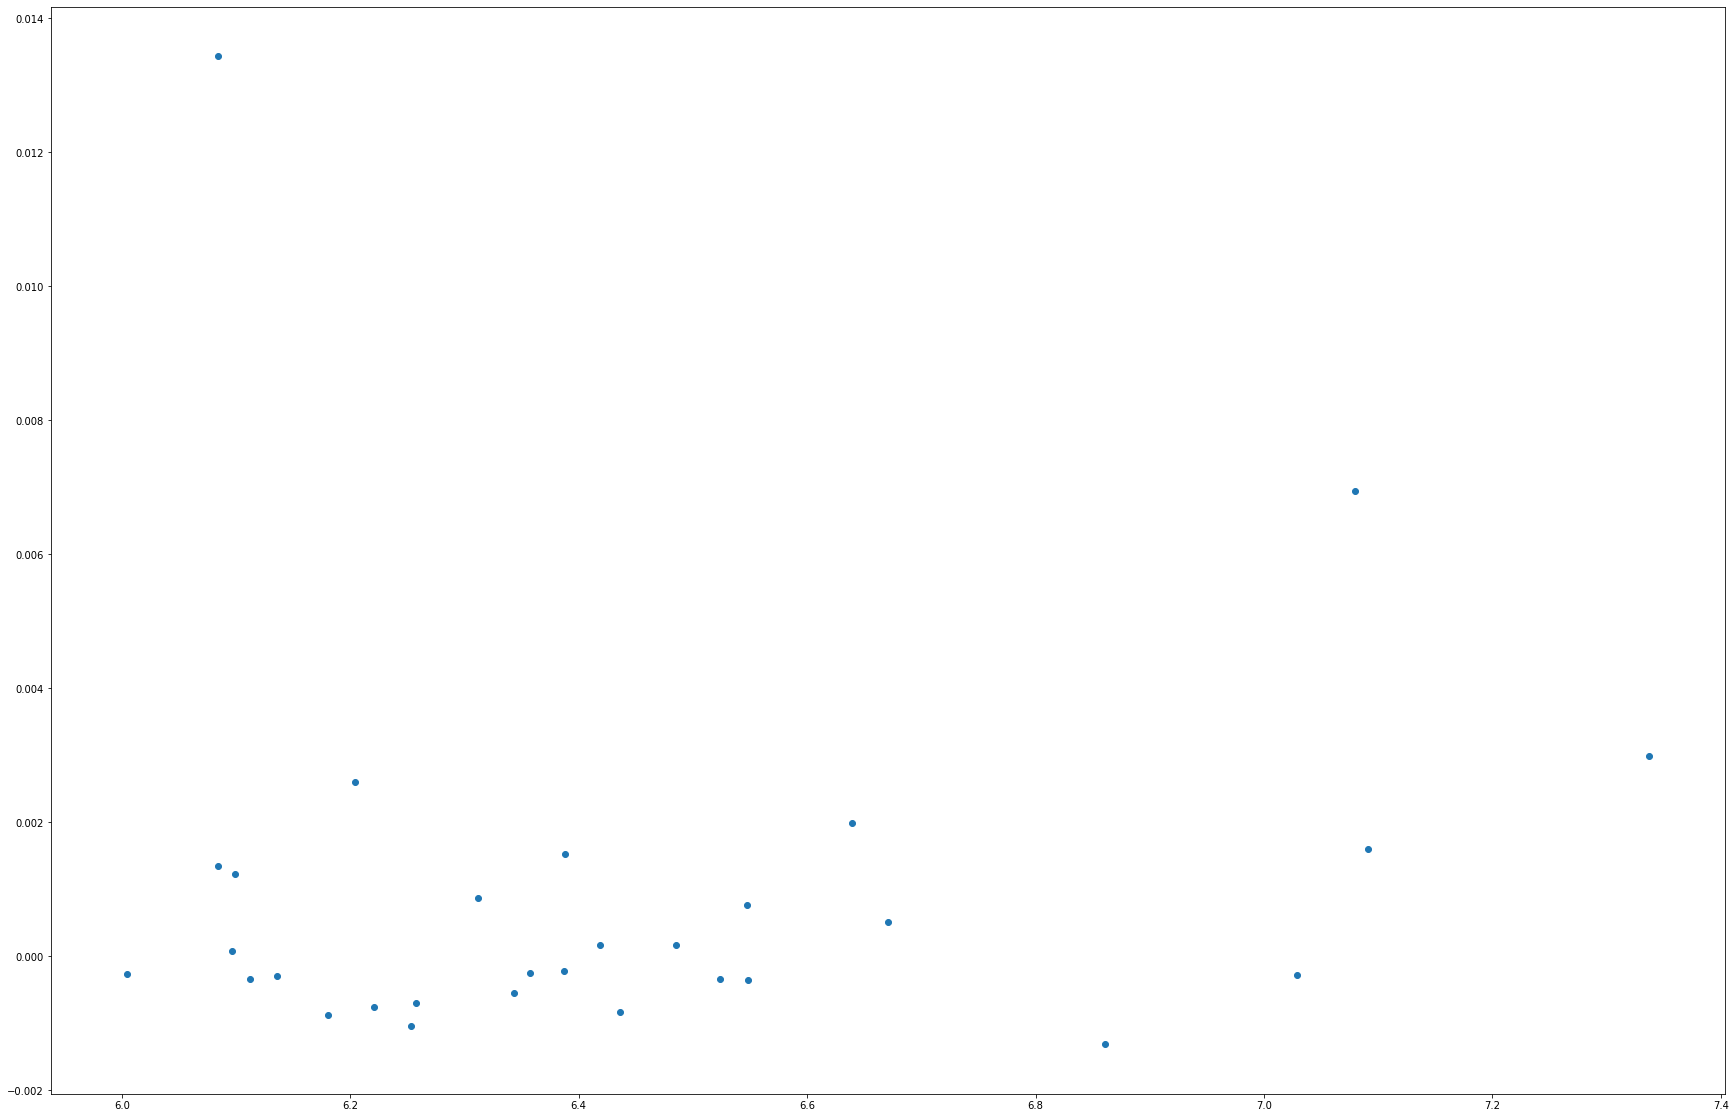

In [89]:
x_values = np.log10(merge_1.StarMass)
#y_values = (comparison_df2.f_esc_1e6-comparison_df2.f_esc_1e5)/comparison_df2.f_esc_1e5
y_values1 = merge_1.f_esc_1e8
y_values2 = merge_1.f_esc_1e9
plt.scatter(x_values, (y_values2-y_values1)/y_values1)
plt.rcParams["figure.figsize"] = (30, 20)
#plt.yscale('log')
#plt.ylim(0.1,50)

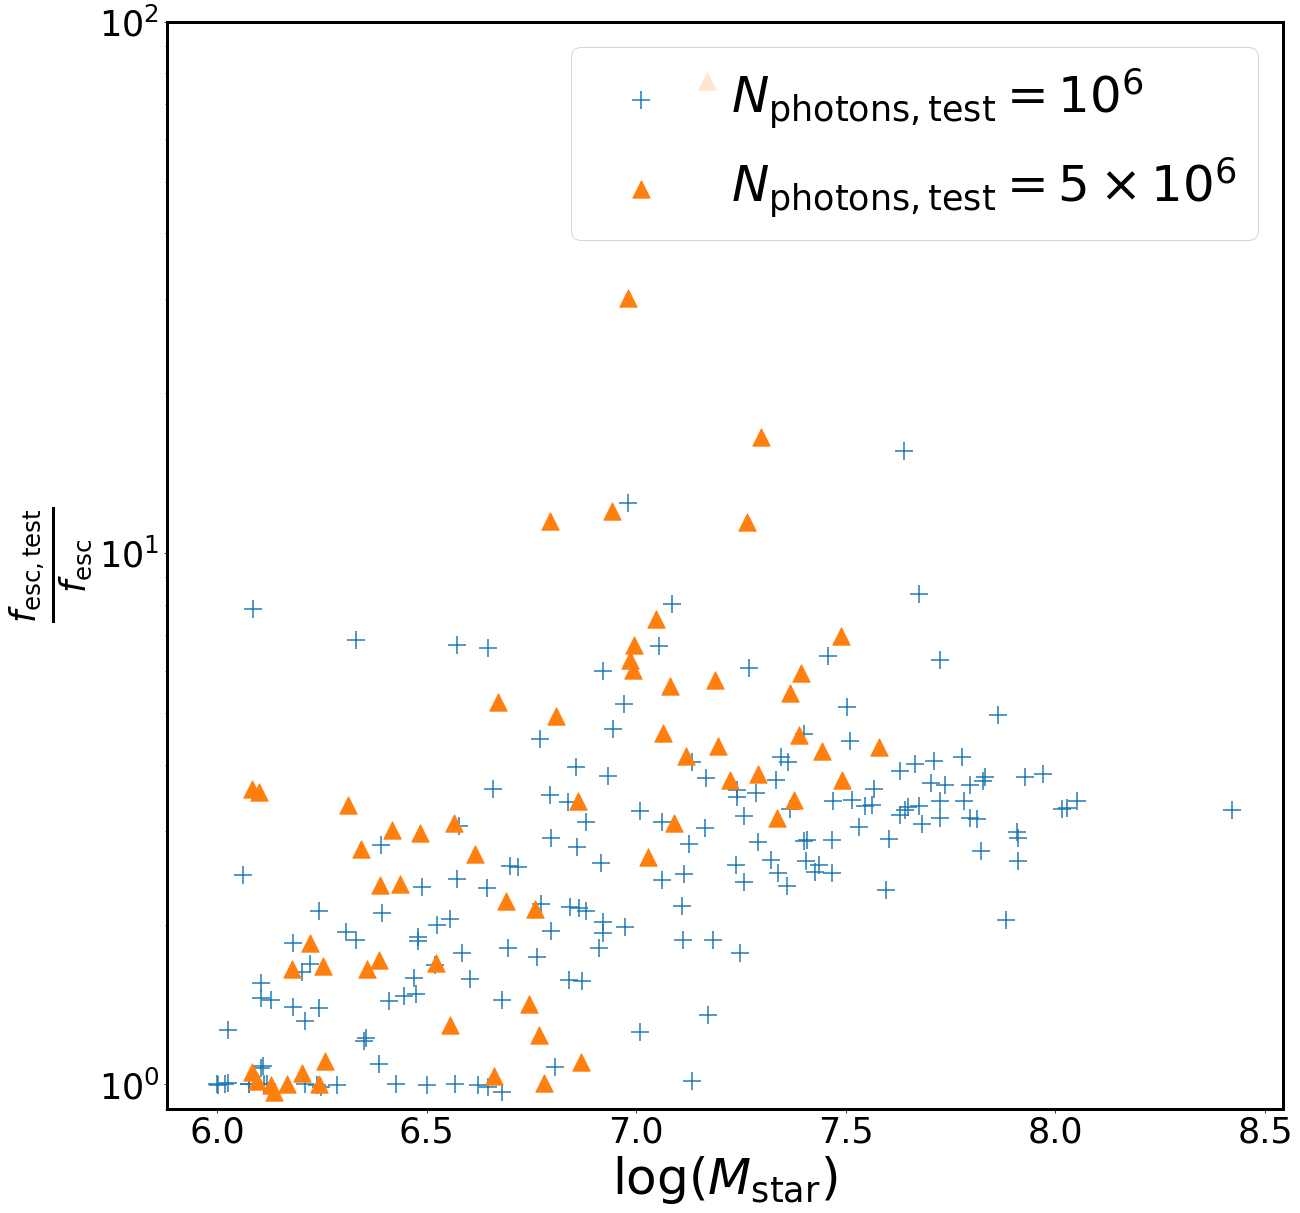

In [73]:
x_values = np.log10(comparison_df2.StarMass)
y_values = comparison_df2.f_esc_1e6/comparison_df2.f_esc_1e5
plt.scatter(x_values, y_values, s=300, marker='+', label='$N_\mathrm{photons, test}=10^6$')

x_values = np.log10(comparison_df3.StarMass)
y_values = comparison_df3.f_esc_5e6/comparison_df3.f_esc_1e5
plt.scatter(x_values, y_values, s=300, marker='^', label=r'$N_\mathrm{photons, test}=5 \times 10^6$')
plt.ylabel(r'$\frac{f_\mathrm{esc, test}}{f_\mathrm{esc}}$', size=50)
plt.xlabel(r'$\log(M_\mathrm{star})$', size=50)
plt.yscale('log')
plt.legend(fontsize=50)
plt.ylim(0.9,100);

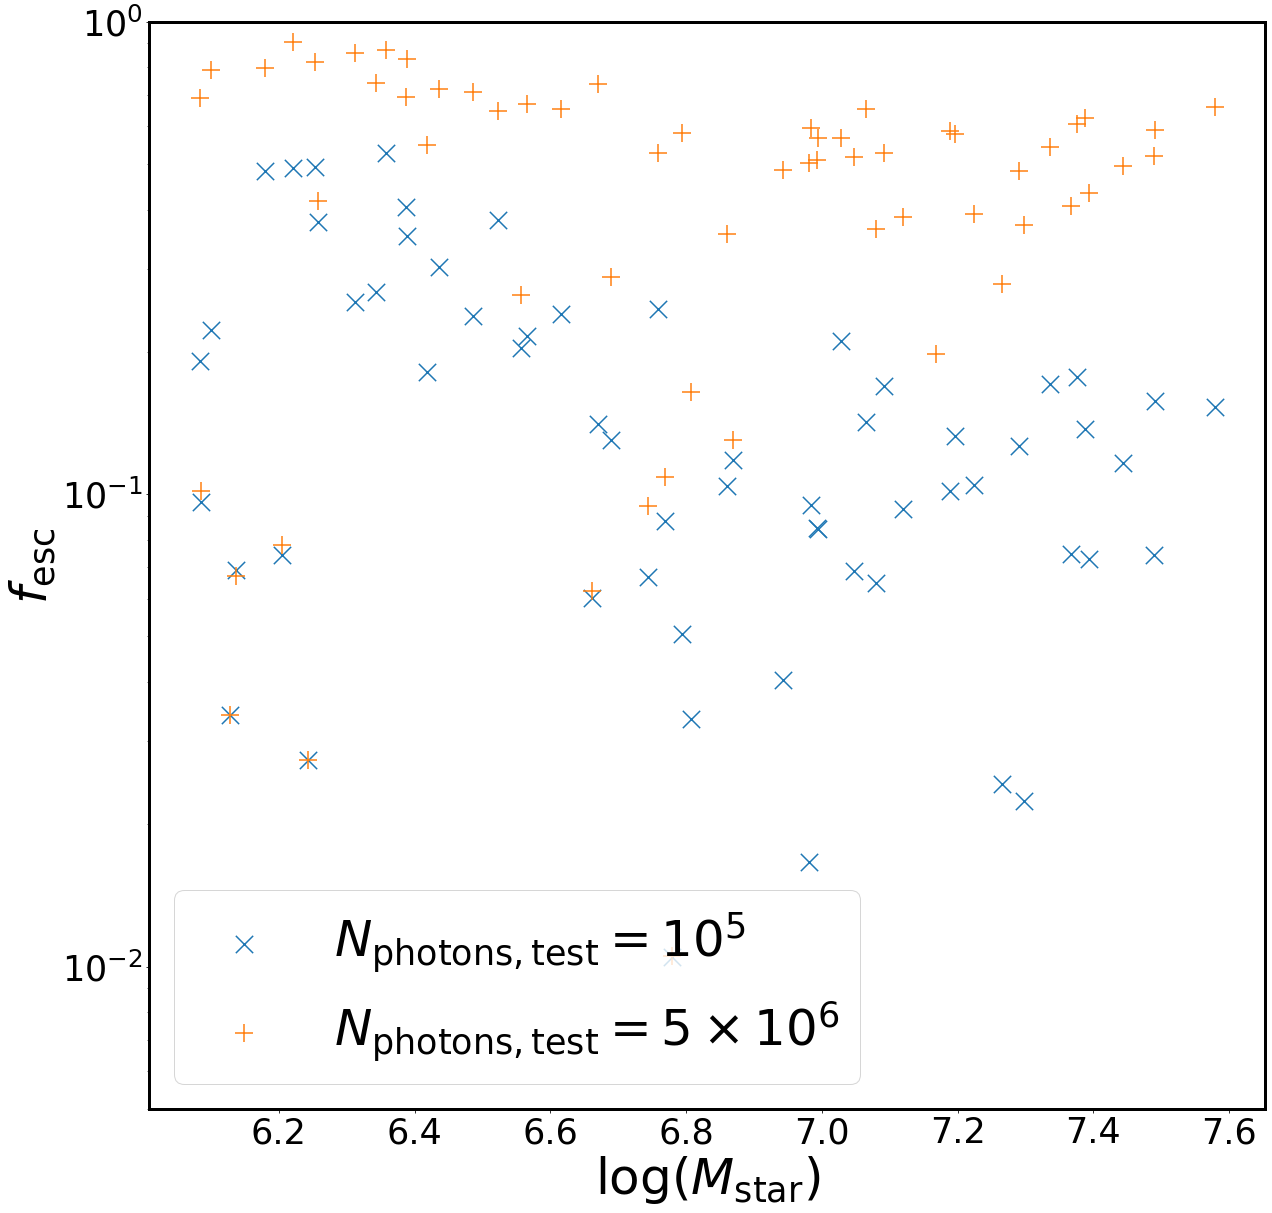

In [68]:
x_values = np.log10(comparison_df3.StarMass)
y_values = comparison_df3.f_esc_1e5
plt.scatter(x_values, y_values, s=300, marker='x', label='$N_\mathrm{photons, test}=10^5$')

x_values = np.log10(comparison_df3.StarMass)
y_values = comparison_df3.f_esc_5e6
plt.scatter(x_values, y_values, s=300, marker='+', label=r'$N_\mathrm{photons, test}=5 \times 10^6$')
plt.ylabel(r'$f_\mathrm{esc}$', size=50)
plt.xlabel(r'$\log(M_\mathrm{star})$', size=50)
plt.yscale('log')
plt.legend(fontsize=50)
plt.ylim(0.005,1);

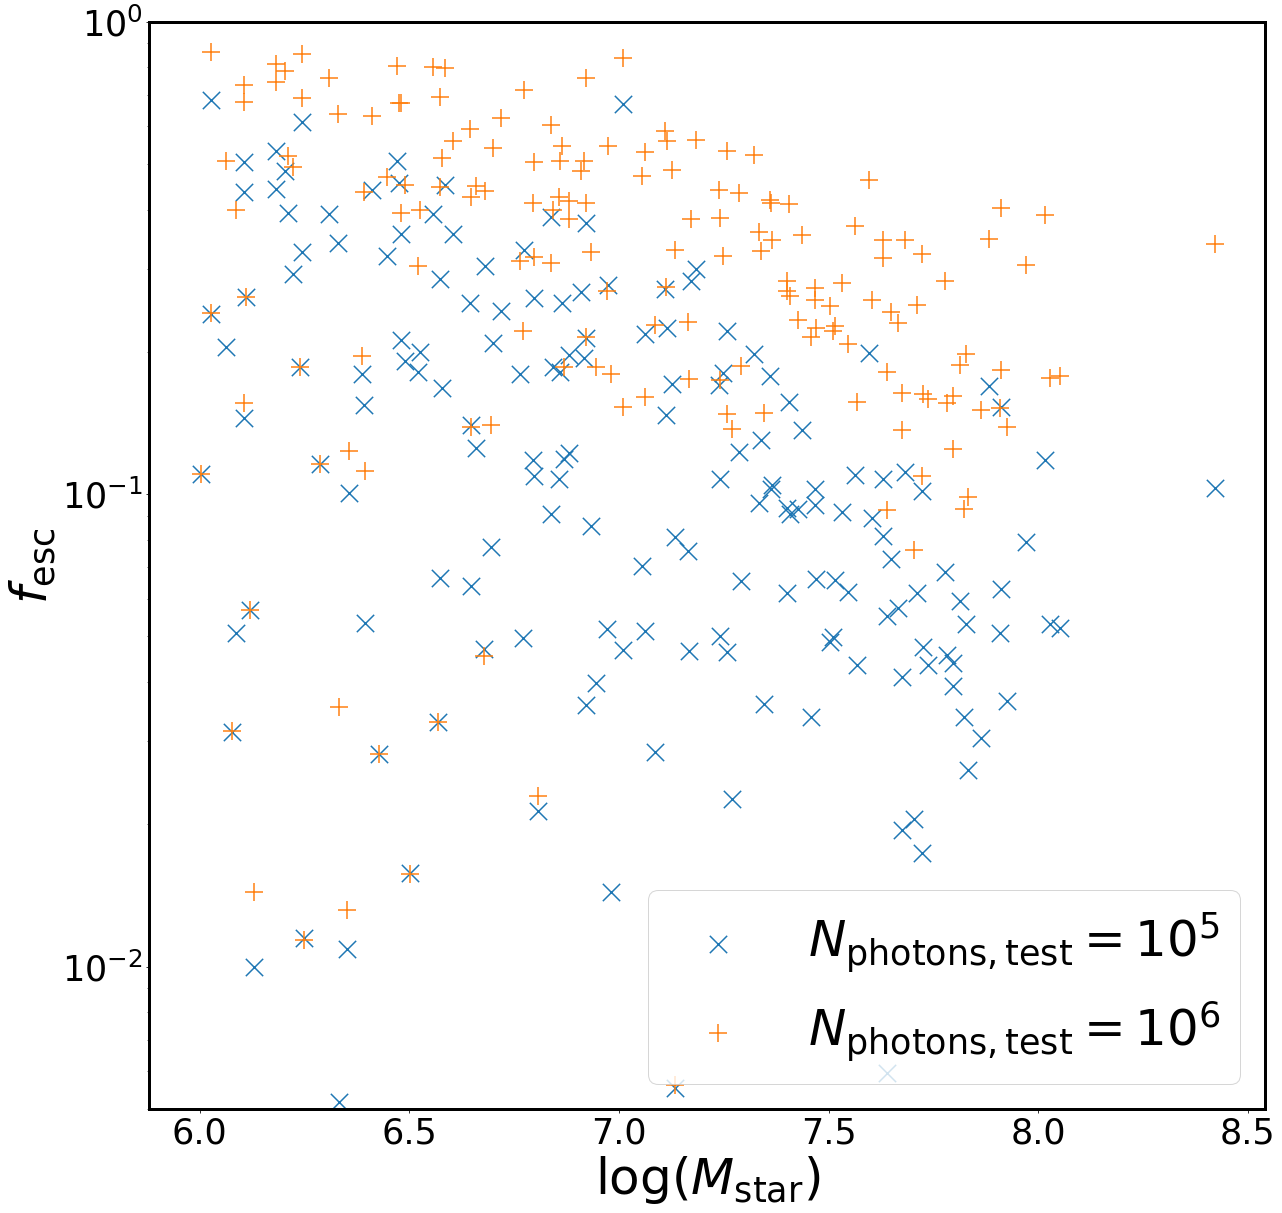

In [69]:
x_values = np.log10(comparison_df2.StarMass)
y_values = comparison_df2.f_esc_1e5
plt.scatter(x_values, y_values, s=300, marker='x', label='$N_\mathrm{photons, test}=10^5$')

x_values = np.log10(comparison_df2.StarMass)
y_values = comparison_df2.f_esc_1e6
plt.scatter(x_values, y_values, s=300, marker='+', label=r'$N_\mathrm{photons, test}=10^6$')
plt.ylabel(r'$f_\mathrm{esc}$', size=50)
plt.xlabel(r'$\log(M_\mathrm{star})$', size=50)
plt.yscale('log')
plt.legend(fontsize=50)
plt.ylim(0.005,1);

In [236]:
df_test = pd.read_pickle('dfs/fid2.pickle')

In [244]:
df_test[(df_test.ID==672) & (df_test.z==6)].f_esc

895    0.025952
Name: f_esc, dtype: float64

In [192]:
comparison_df3[comparison_df3.ID==1029].GridSize

30    93
Name: GridSize, dtype: int64

In [219]:
test = df[(df.ID==672) & (df.z==6)]

In [243]:
df_test.f_esc

0        0.002808
1        0.061407
2        0.000947
3        0.059300
4        0.102726
           ...   
10658    0.147129
10659    0.005572
10660    0.082814
10661    0.013817
10662    0.174854
Name: f_esc, Length: 10663, dtype: float64

In [234]:
np.log10(test.HaloMass/0.6774*1e10)

890    10.577773
Name: HaloMass, dtype: float64

In [224]:
test.per_source.values

array([array([2.78378027e-40, 5.65760252e-37, 4.87659614e-46, ...,
                  nan,            nan, 5.77830980e-01])], dtype=object)

In [215]:
df[df.ID==672][['f_esc','z']]

,f_esc,z
890,0.032748,6
5309,0.021638,8
7570,0.255976,10


In [191]:
comparison_df3[comparison_df3.ID==1029].f_esc_1e5
comparison_df3[comparison_df3.ID==1029].f_esc_5e6

30    0.002568
Name: f_esc_1e5, dtype: float64

30    0.198295
Name: f_esc_5e6, dtype: float64

,ID,GridSize,f_esc_1e5,f_esc_5e6
13,1812,130,0.074181,0.518824
22,8727,100,0.084667,0.510517
28,2634,88,0.094889,0.595863
30,1029,93,0.002568,0.198295
37,2310,83,0.040398,0.484773
39,3203,80,0.050570,0.580679
44,919,184,0.024297,0.277886
46,1940,70,0.084233,0.566032
47,1201,86,0.016678,0.502794
50,1285,101,0.022462,0.371483


In [199]:
from crashpy.dataclasses.simulation import LoadedSimulation as Sim
from crashpy.escapeFraction import computeEscFrac
from crashpy import utilities
import h5py

seed = 2
prec = 0.05
r_scale = 1.0
threads = 1

#compute_f_esc(prec=config.f_esc_prec, r_scales=config.f_esc_rscales, overwrite=config.f_esc_overwrite)
simpath_1e5  = '/freya/ptmp/mpa/mglatzle/TNG_f_esc/full_esc/run/L35n2160TNG/sn008/g1029'
simpath_5e6  = '/freya/ptmp/mpa/mglatzle/TNG_f_esc/new_numerical_5e6/run/L35n2160TNG/sn008/g1029'

sim_1e5 = Sim(simpath_1e5)
sim_5e6 = Sim(simpath_5e6)

physfiles_1e5 = sim_1e5.getAllphysfiles()
physfiles_1e5 = sim_5e6.getAllphysfiles()

result_1e5 = computeEscFrac(sim=sim_1e5, physfileNumber=physfiles_1e5[4].info['number'],
                               delta_rel=prec, r_scale=r_scale,
                               n_threads=threads,
                               seed=seed)

result_5e6 = computeEscFrac(sim=sim_5e6, physfileNumber=physfiles_1e5[4].info['number'],
                               delta_rel=prec, r_scale=r_scale,
                               n_threads=threads,
                               seed=seed)

In [200]:
result_1e5['cum']
result_5e6['cum']

0.002642088876139741

0.2025633179218717

In [201]:
result_1e5.keys()

dict_keys(['freqs', 'emitted_photons', 'escaped_photons', 'per_source', 'per_freq', 'cum', 'n_iterations', 'chunk_size'])

In [202]:
def redshift_to_snap(redshift):
    snapnames = {6:'sn013', 8:'sn008', 10:'sn004'}
    return snapnames[redshift]

def source_dist_lum(ID, redshift, conf, side_length):
    snap = redshift_to_snap(redshift)
    path_sources = f'/ptmp/mpa/mglatzle/TNG_f_esc/{conf}/run/L35n2160TNG/{snap}/g{ID}/Input/sources_ic00.in'
    
    # 0.5 is needed to take into account that the sources are at the center of the grid voxel, move origin to halo center
    coord = pd.read_csv(path_sources, delim_whitespace=True, header=None, usecols=[0,1,2])+0.5-side_length/2
    lum = pd.read_csv(path_sources, delim_whitespace=True, header=None, usecols=[3])
    rel_dist = np.sqrt(np.sum(coord**2, axis=1))*2/side_length
    
    return rel_dist

In [285]:
dist_1812 = np.array(source_dist_lum(ID=1812, redshift=6, conf='full_esc', side_length=130))
dist_1029 = np.array(source_dist_lum(ID=1029, redshift=8, conf='full_esc', side_length=93))
dist_663 = np.array(source_dist_lum(ID=663, redshift=10, conf='full_esc', side_length=75))

In [325]:
per_freq_1812_5e6 = df_5e6[df_5e6.ID==1812].per_freq.values[0]
per_freq_1029_5e6 = df_5e6[df_5e6.ID==1029].per_freq.values[0]
per_freq_663_5e6 = df_5e6[df_5e6.ID==663].per_freq.values[0]

per_freq_1812_1e5 = df[(df.ID==1812) & (df.z==6)].per_freq.values[0]
per_freq_1029_1e5 = df[(df.ID==1029) & (df.z==8)].per_freq.values[0]
per_freq_663_1e5 = df[(df.ID==663) & (df.z==10)].per_freq.values[0]

In [328]:
h_p = 6.62607004e-34
e = 1.60217662e-19
freq_energy = df[(df.ID==663) & (df.z==10)].frequencies.values[0]*h_p/e

Text(0, 0.5, '$\\langle f_\\mathrm{esc} \\rangle$')

Text(0.5, 0, '$ E(\\gamma)[\\mathrm{eV}] $')

(0.0, 1.0)

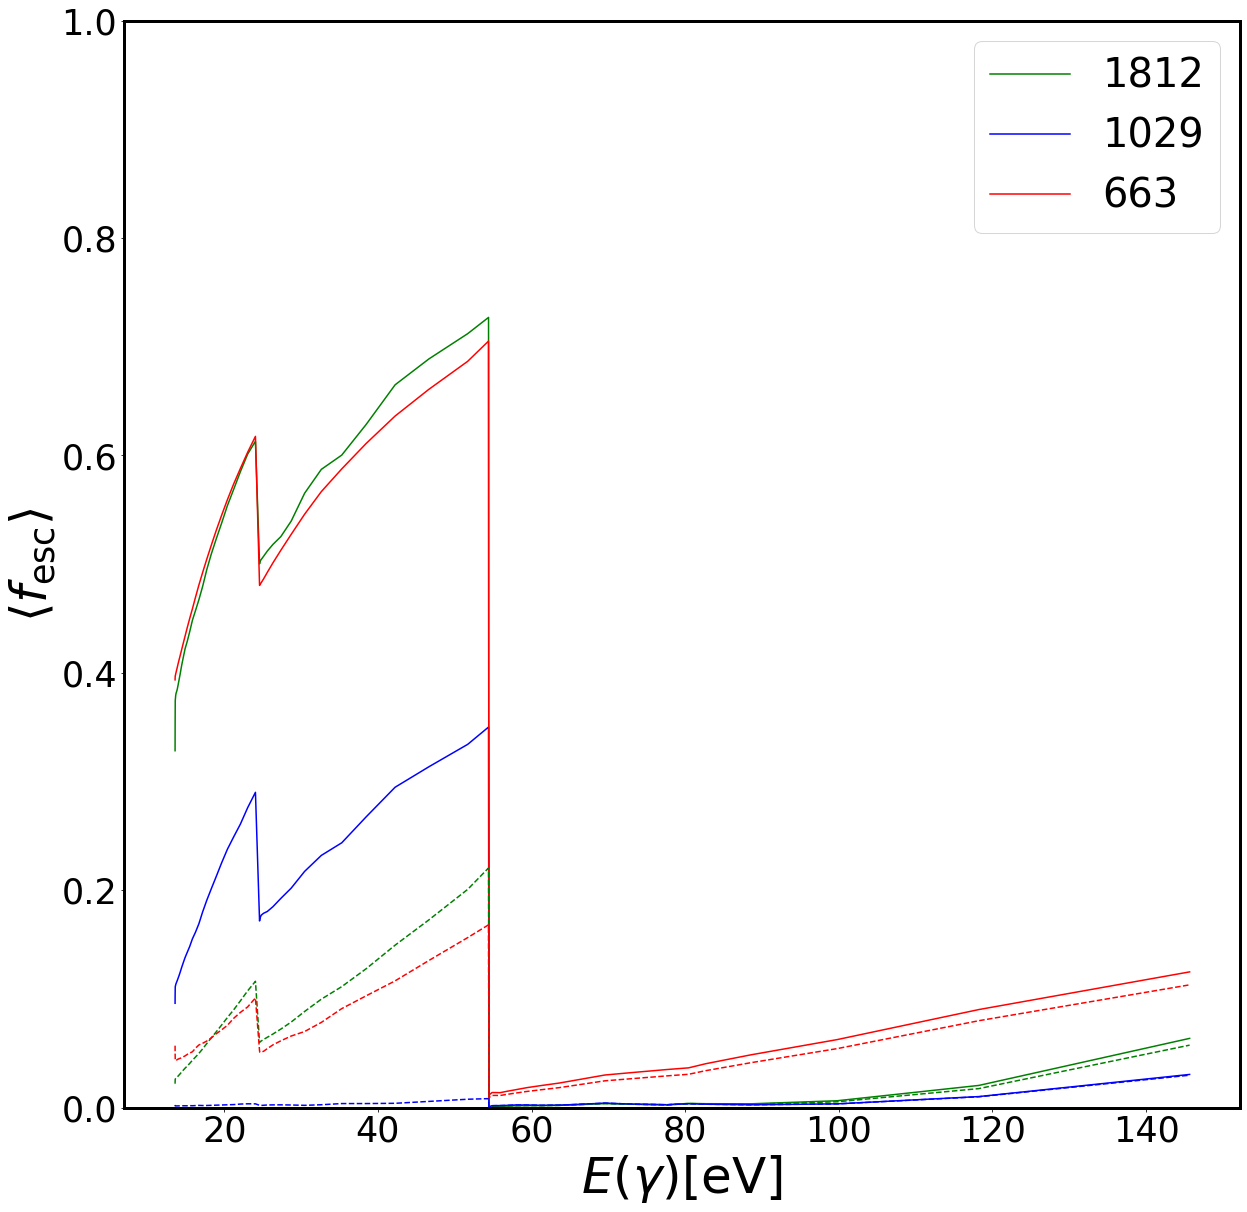

In [336]:
plt.plot(freq_energy, per_freq_1812_5e6, label='1812', color='green')
plt.plot(freq_energy, per_freq_1029_5e6, label='1029', color='blue')
plt.plot(freq_energy, per_freq_663_5e6, label='663', color='red')
plt.plot(freq_energy, per_freq_1812_1e5, linestyle='--', color='green')
plt.plot(freq_energy, per_freq_1029_1e5, linestyle='--', color='blue')
plt.plot(freq_energy, per_freq_663_1e5, linestyle='--', color='red')
plt.legend(fontsize=40)
plt.ylabel(r'$\langle f_\mathrm{esc} \rangle$', size=50)
plt.xlabel(r'$ E(\gamma)[\mathrm{eV}] $', size=50)
#plt.yscale('log')
plt.ylim([0,1.0])

In [309]:
ratio_1812 = comparison_df3[comparison_df3.ID==1812].per_source.values[0]/df_5e6[df_5e6.ID==1812].per_source.values[0]
ratio_1029 = comparison_df3[comparison_df3.ID==1029].per_source.values[0]/df_5e6[df_5e6.ID==1029].per_source.values[0]
ratio_663 = comparison_df3[comparison_df3.ID==663].per_source.values[0]/df_5e6[df_5e6.ID==663].per_source.values[0]

In [306]:
comparison_df3[comparison_df3.ID==663].per_source

58    [5.887854882599587e-17, 2.3964642453928703e-07...
Name: per_source, dtype: object

In [305]:
df_5e6[df_5e6.ID==663].per_source

68    [2.3300233589663327e-16, 0.07592677768255546, ...
Name: per_source, dtype: object

(0.0, 1.2)

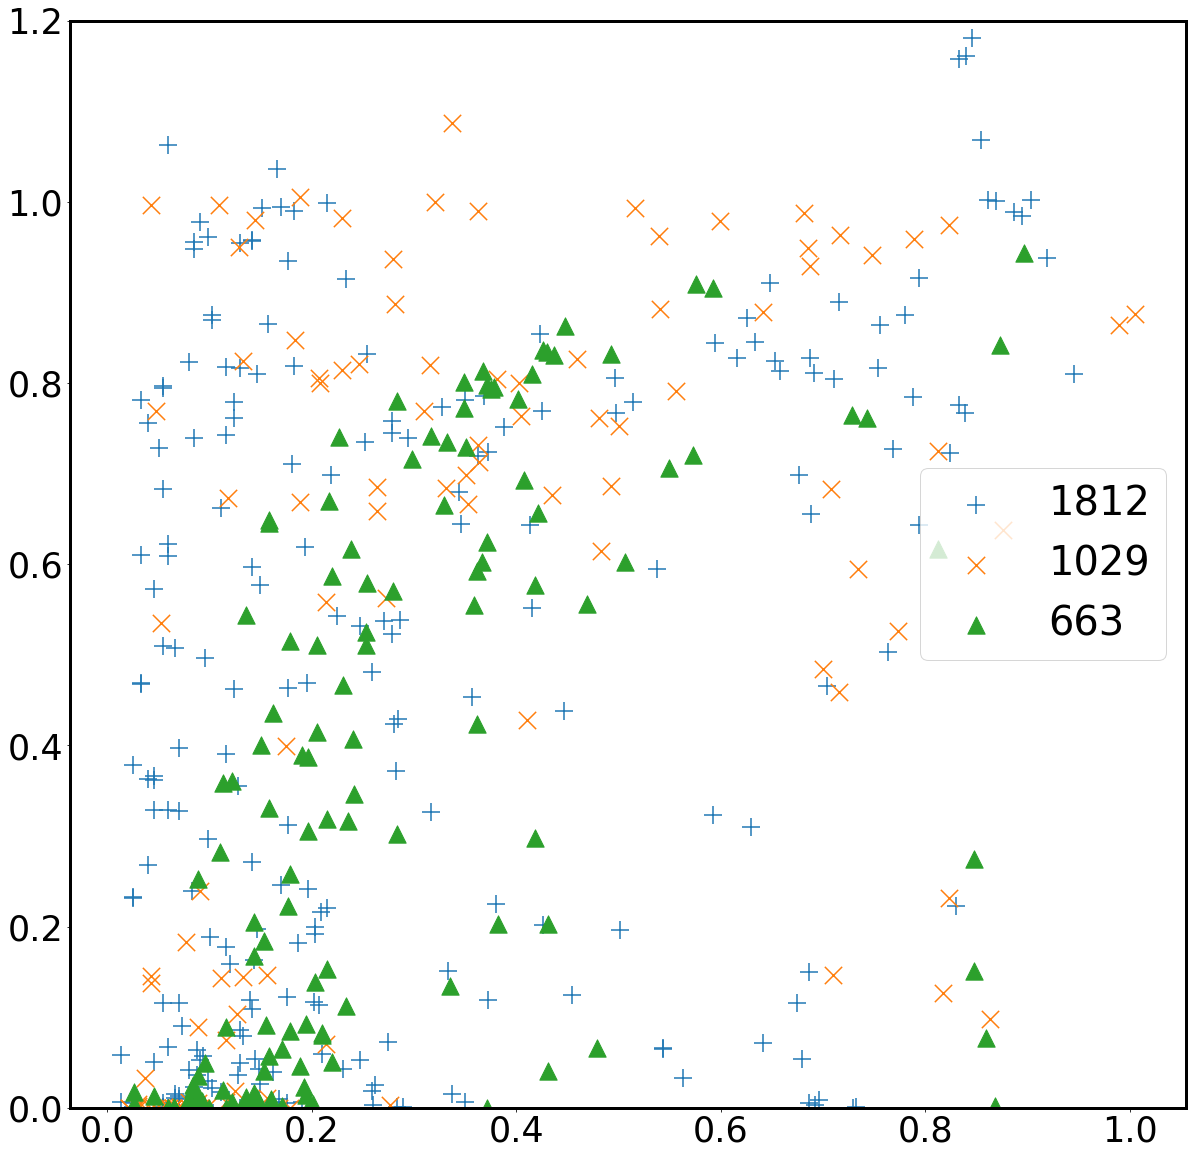

In [316]:
plt.scatter(dist_1812, ratio_1812, s=300, marker='+', label='1812')
plt.scatter(dist_1029, ratio_1029, s=300, marker='x', label='1029')
plt.scatter(dist_663, ratio_663, s=300, marker='^', label='663')
plt.legend(fontsize=40)
#plt.yscale('log')
plt.ylim([0,1.2])

In [392]:
comparison_df3[comparison_df3.ID==1029].f_esc_5e6

30    0.198295
Name: f_esc_5e6, dtype: float64

In [388]:
df_5e6[df_5e6.ID==1029].f_esc

30    0.198295
Name: f_esc, dtype: float64

In [377]:
pre_conv_1e6 = pd.read_pickle('dfs/convergence_test_1e6.pickle')
pre_conv_5e6 = pd.read_pickle('dfs/new_numerical_5e6.pickle')
conv_1e7 = pd.read_pickle('dfs/convergence_test_1e7.pickle')
conv_1e8 = pd.read_pickle('dfs/convergence_test_1e8.pickle')

In [362]:
df = pd.read_pickle('dfs/full_esc.pickle')

In [378]:
conv_1e5 = df.merge(conv_1e7[['ID', 'z']], on=['ID', 'z'])
conv_5e6 = pre_conv_5e6.merge(conv_1e7[['ID', 'z']], on=['ID', 'z'])
conv_1e6 = pre_conv_1e6.merge(conv_1e7[['ID', 'z']], on=['ID', 'z'])

In [380]:
update_df(conv_1e5)
update_df(conv_1e6)
update_df(conv_5e6)
update_df(conv_1e7)
update_df(conv_1e8)

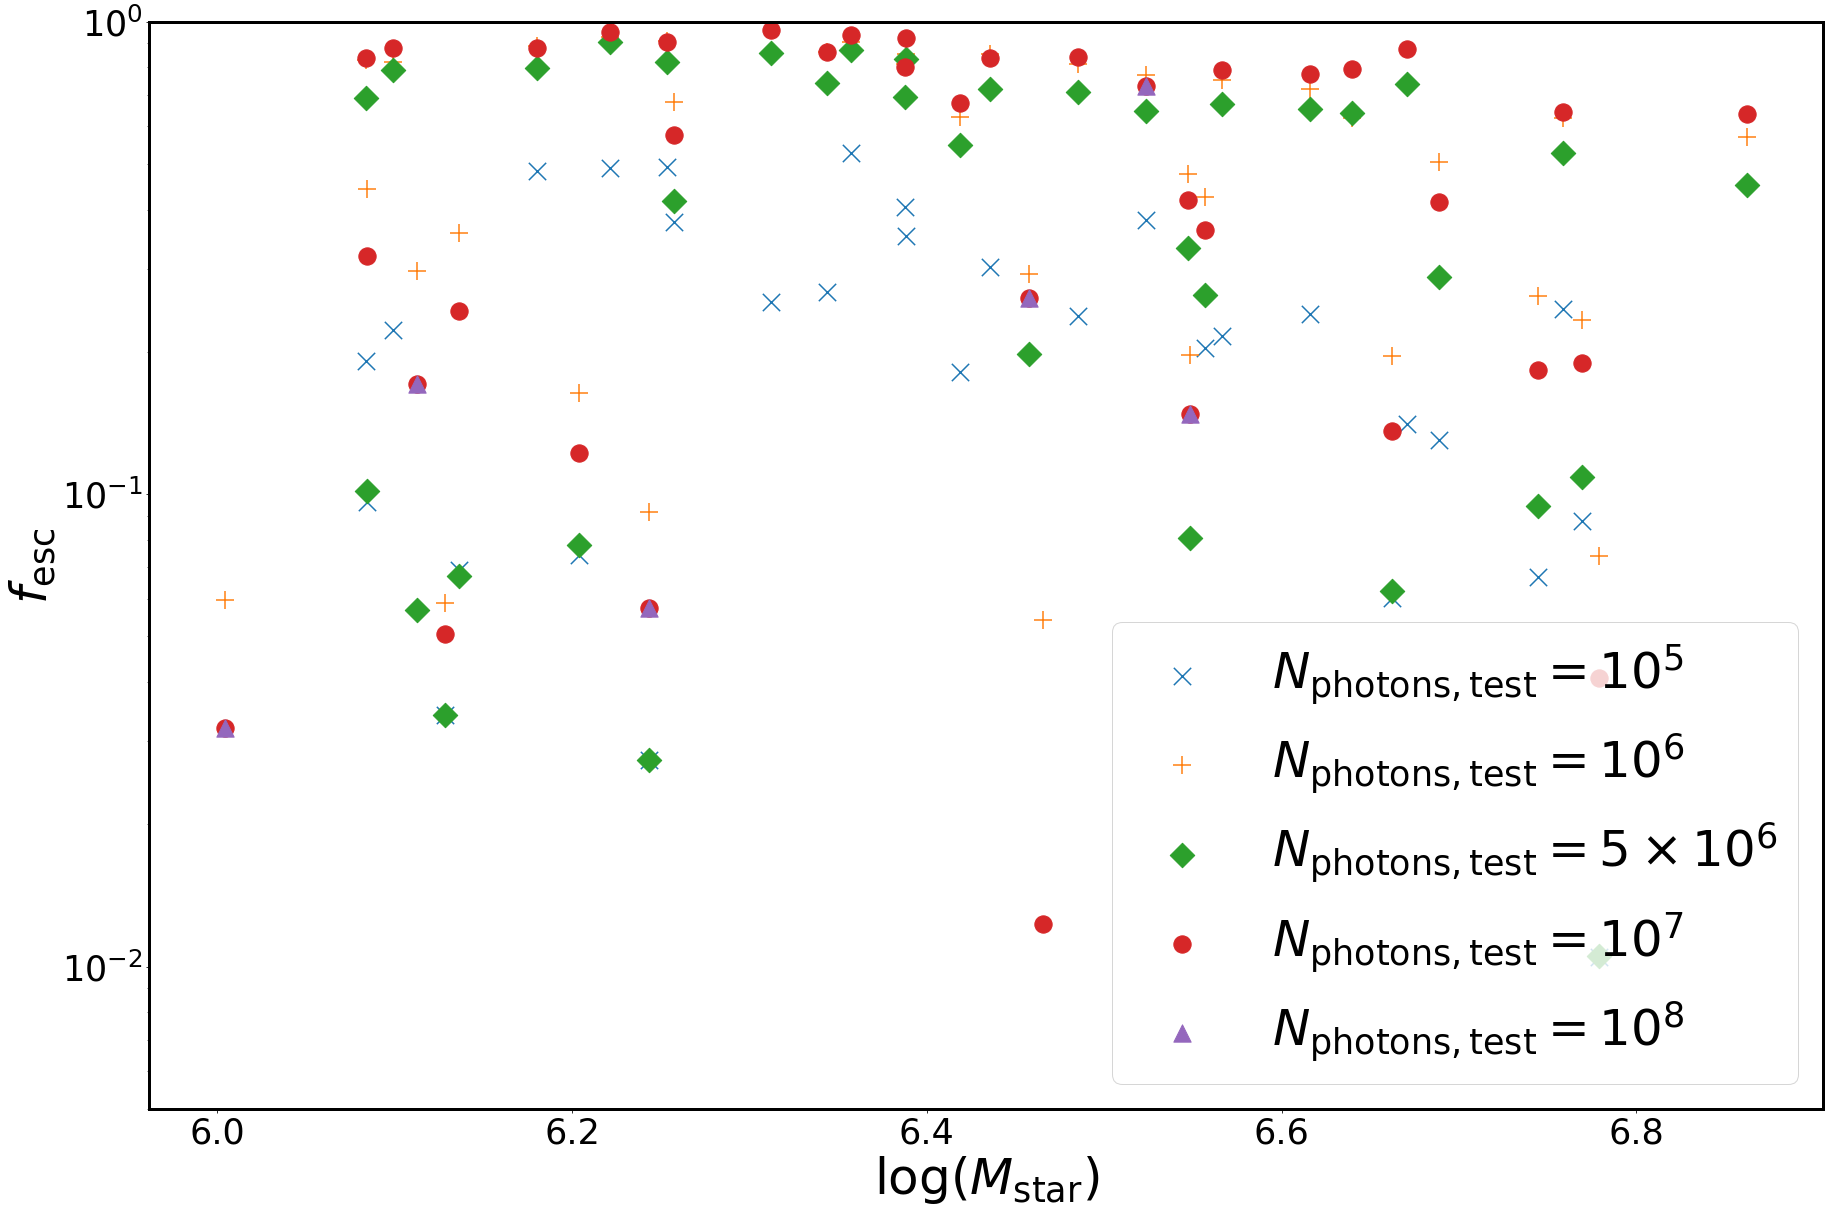

In [384]:
x_values = np.log10(conv_1e5.StarMass)
y_values = conv_1e5.f_esc
plt.scatter(x_values, y_values, s=300, marker='x', label='$N_\mathrm{photons, test}=10^5$')

x_values = np.log10(conv_1e6.StarMass)
y_values = conv_1e6.f_esc
plt.scatter(x_values, y_values, s=300, marker='+', label=r'$N_\mathrm{photons, test}=10^6$')

x_values = np.log10(conv_5e6.StarMass)
y_values = conv_5e6.f_esc
plt.scatter(x_values, y_values, s=300, marker='D', label=r'$N_\mathrm{photons, test}=5 \times 10^6$')

x_values = np.log10(conv_1e7.StarMass)
y_values = conv_1e7.f_esc
plt.scatter(x_values, y_values, s=300, marker='o', label=r'$N_\mathrm{photons, test}=10^7$')


x_values = np.log10(conv_1e8.StarMass)
y_values = conv_1e8.f_esc
plt.scatter(x_values, y_values, s=300, marker='^', label=r'$N_\mathrm{photons, test}=10^8$')

plt.ylabel(r'$f_\mathrm{esc}$', size=50)
plt.xlabel(r'$\log(M_\mathrm{star})$', size=50)
plt.rcParams["figure.figsize"] = (30, 20)
plt.yscale('log')
plt.rcParams["figure.figsize"] = (30, 20)
plt.legend(fontsize=50)
plt.ylim(0.005,1);

In [385]:
test_1e6 = pd.read_pickle('dfs/convergence_test_1e6.pickle')
test_5e6 = pd.read_pickle('dfs/new_numerical_5e6.pickle')
test_1e7 = pd.read_pickle('dfs/convergence_test_1e7.pickle')
test_1e8 = pd.read_pickle('dfs/convergence_test_1e8.pickle')

update_df(test_1e6)
update_df(test_5e6)
update_df(test_1e7)
update_df(test_1e8)

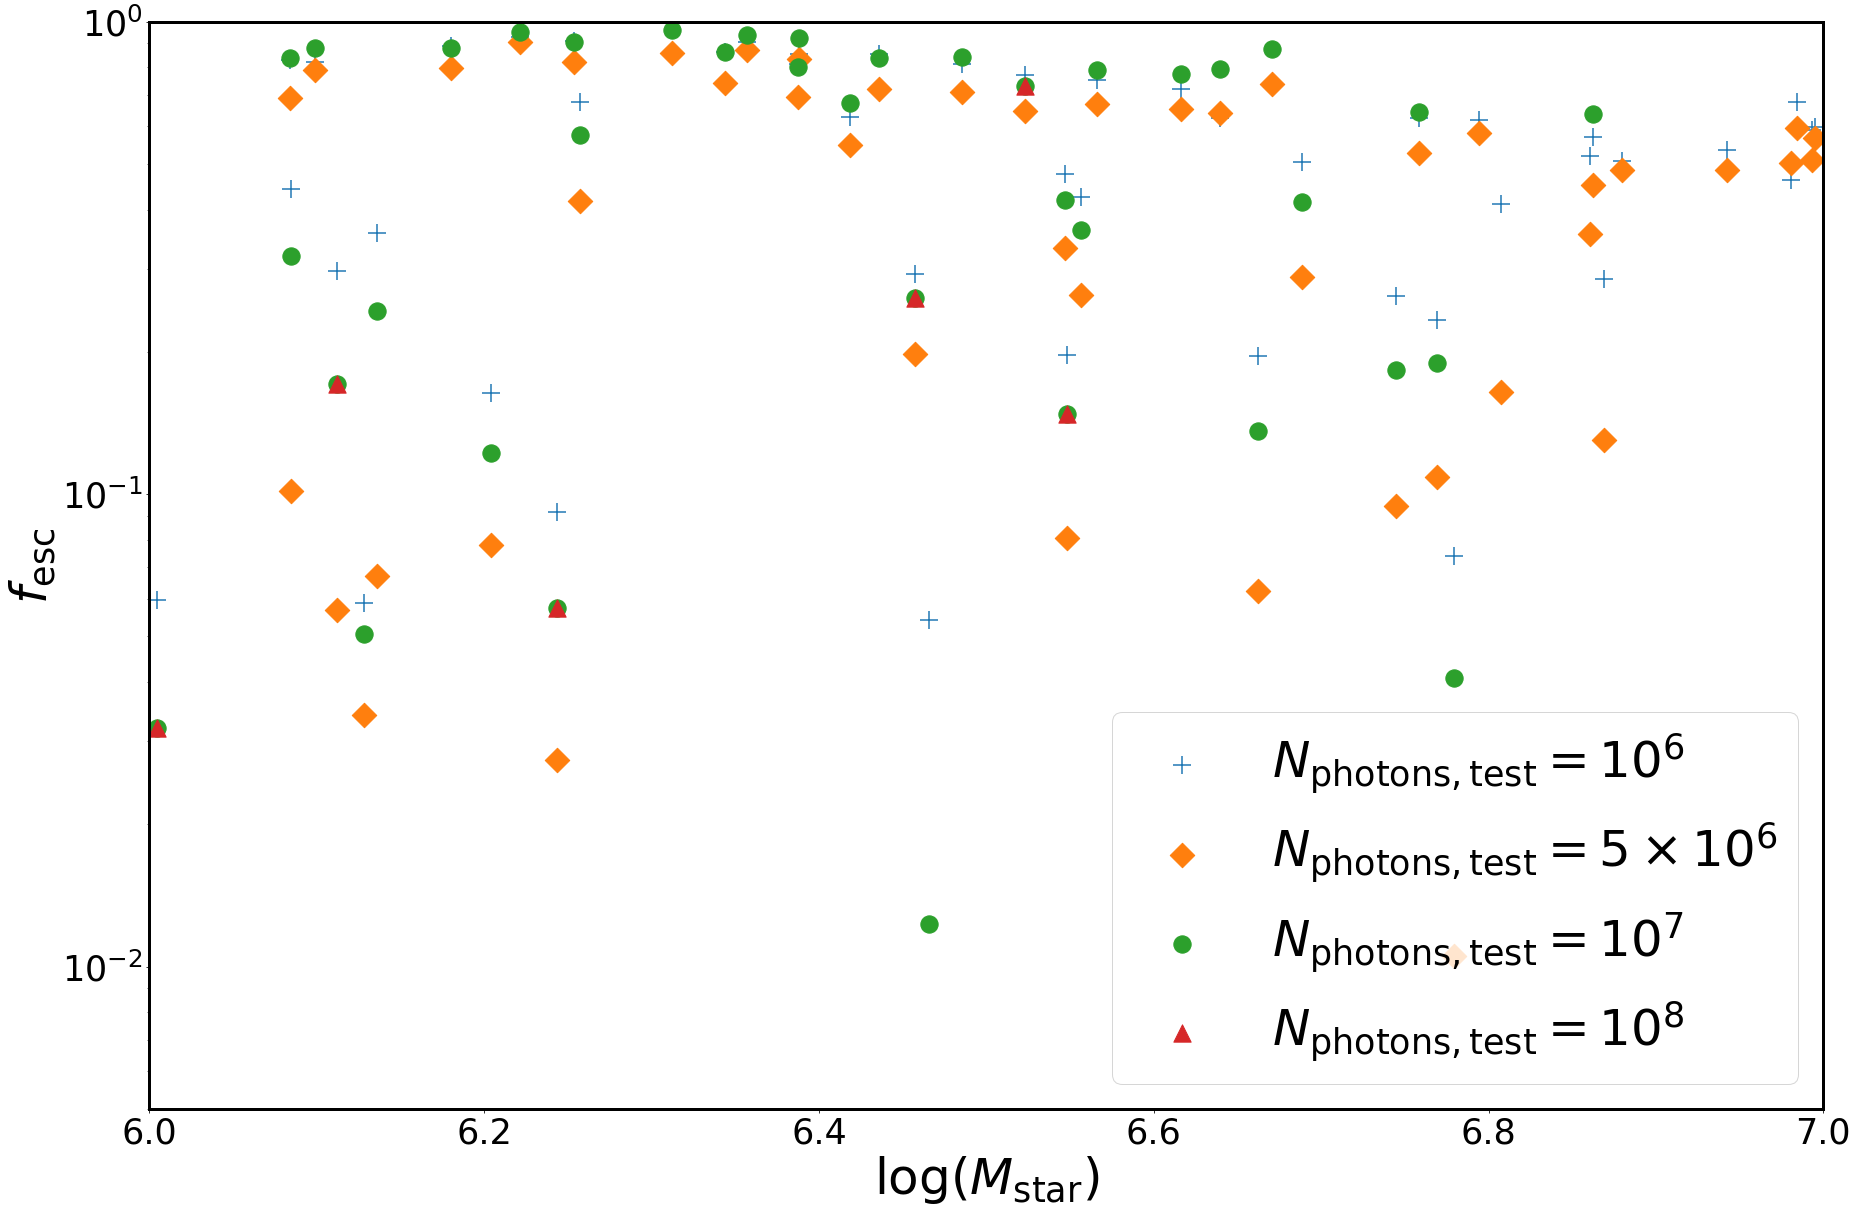

In [387]:
x_values = np.log10(test_1e6.StarMass)
y_values = test_1e6.f_esc
plt.scatter(x_values, y_values, s=300, marker='+', label=r'$N_\mathrm{photons, test}=10^6$')

x_values = np.log10(test_5e6.StarMass)
y_values = test_5e6.f_esc
plt.scatter(x_values, y_values, s=300, marker='D', label=r'$N_\mathrm{photons, test}=5 \times 10^6$')

x_values = np.log10(test_1e7.StarMass)
y_values = test_1e7.f_esc
plt.scatter(x_values, y_values, s=300, marker='o', label=r'$N_\mathrm{photons, test}=10^7$')


x_values = np.log10(test_1e8.StarMass)
y_values = test_1e8.f_esc
plt.scatter(x_values, y_values, s=300, marker='^', label=r'$N_\mathrm{photons, test}=10^8$')

plt.ylabel(r'$f_\mathrm{esc}$', size=50)
plt.xlabel(r'$\log(M_\mathrm{star})$', size=50)
plt.rcParams["figure.figsize"] = (30, 20)
plt.yscale('log')
plt.rcParams["figure.figsize"] = (30, 20)
plt.legend(fontsize=50)
plt.ylim(0.005,1)
plt.xlim(6,7);

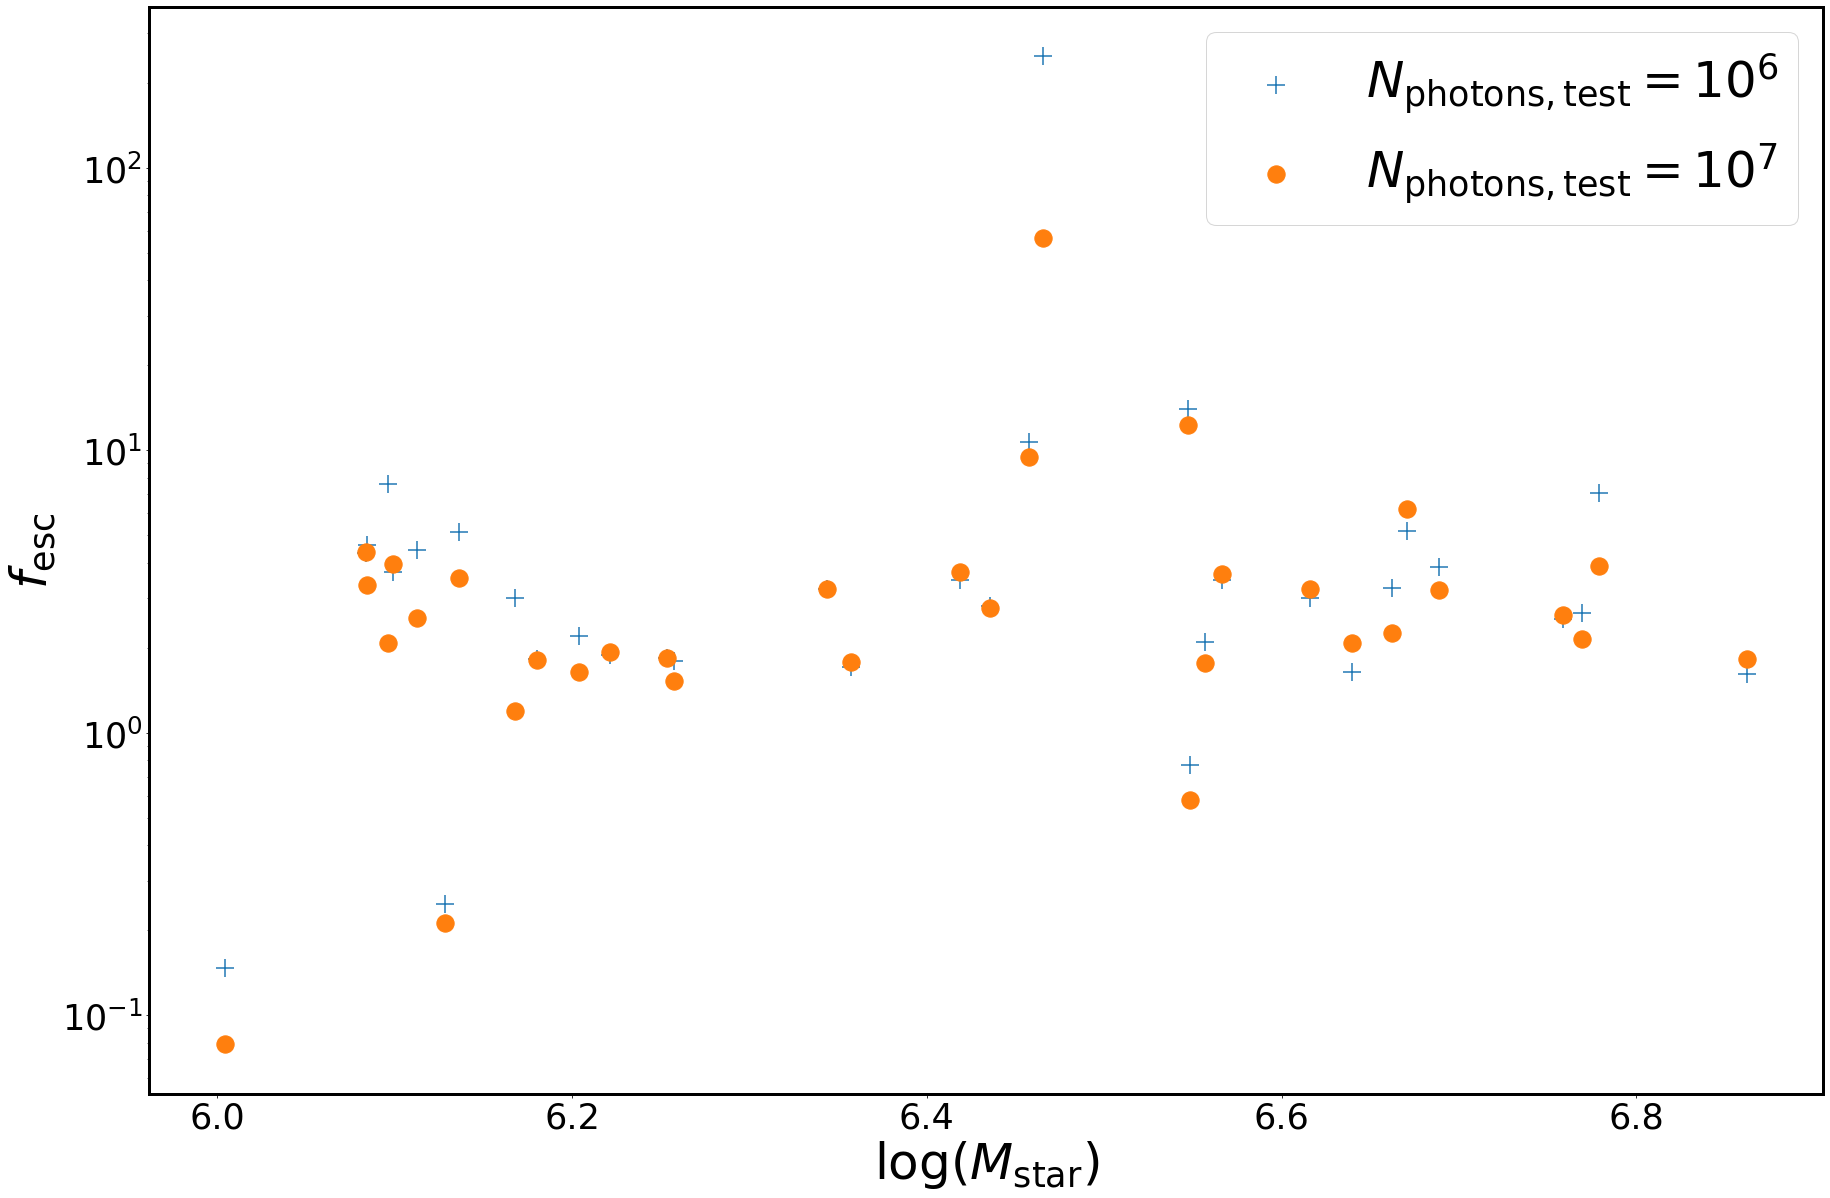

In [382]:
# x_values = np.log10(conv_1e5.StarMass)
# y_values = conv_1e5.f_esc
# plt.scatter(x_values, y_values, s=300, marker='x', label='$N_\mathrm{photons, test}=10^5$')

x_values = np.log10(conv_1e6.StarMass)
y_values = conv_1e6.f_esc/conv_1e5.f_esc
plt.scatter(x_values, y_values, s=300, marker='+', label=r'$N_\mathrm{photons, test}=10^6$')

x_values = np.log10(conv_1e7.StarMass)
y_values = conv_1e7.f_esc/conv_1e5.f_esc
plt.scatter(x_values, y_values, s=300, marker='o', label=r'$N_\mathrm{photons, test}=10^7$')


# x_values = np.log10(conv_1e8.StarMass)
# y_values = conv_1e8.f_esc
# plt.scatter(x_values, y_values, s=300, marker='^', label=r'$N_\mathrm{photons, test}=10^8$')

plt.ylabel(r'$f_\mathrm{esc}$', size=50)
plt.xlabel(r'$\log(M_\mathrm{star})$', size=50)
plt.rcParams["figure.figsize"] = (30, 20)
plt.yscale('log')
plt.legend(fontsize=50);
#plt.ylim(0.005,1);


In [48]:
physfile_test[4].info['number']

'05'

In [54]:
from crashpy.dataclasses.simulation import LoadedSimulation as Sim
from crashpy.escapeFraction import computeEscFrac
from multiprocessing import Pool
from crashpy import utilities
import h5py

seed = 42
#simpath_test  = '/freya/ptmp/mpa/mglatzle/TNG_f_esc/esc_analysis/run/L35n2160TNG/sn004/g6428'
simpath_test  = '/freya/ptmp/mpa/mglatzle/TNG_f_esc/esc_analysis/run/L35n2160TNG/sn004/g6625'
sim_test= Sim(simpath_test)

physfile_test = sim_test.getAllphysfiles()[-1]

r = computeEscFrac(sim_test, physfileNumber=physfile_test.info['number'],
                               delta_rel=0.0001, r_scale=1.0,
                               n_threads=8,
                               seed=seed)
def compute_f_esc(simpath, prec, r_scales, overwrite=False):
    sim = Sim(simpath)
    prec_str = utilities.siunitStr(prec, 1, leading_one=True)

    out_string = []
    for physfile in sim.getAllphysfiles():
        outfile = config.f_esc_file(physfile)
        for r_scale in r_scales:
            rscale_str = utilities.siunitStr(r_scale, 1, leading_one=True)
            if os.path.isfile(outfile):
                with h5py.File(outfile, 'r') as ff:
                    if prec_str in ff:
                        if rscale_str in ff[prec_str] and not overwrite:
                            out_string.append(
                                f"Physfile {physfile.getNumber()}: Nothing to do."
                            )
                            continue

            r = computeEscFrac(sim, physfileNumber=physfile.info['number'],
                               delta_rel=prec, r_scale=r_scale,
                               n_threads=config.f_esc_threads,
                               seed=config.f_esc_seed)
            with h5py.File(outfile, 'a') as ff:
                if prec_str not in ff:
                    ff.create_group(prec_str)
                if rscale_str not in ff[prec_str]:
                    ff[prec_str].create_group(rscale_str)
                for key in r.keys():
                    if key in ff[prec_str][rscale_str]:
                        del ff[prec_str][rscale_str][key]
                    ff[prec_str][rscale_str][key] = r[key]
            out_string.append(
                f"Physfile {physfile.getNumber()}: "
                f"Number of iterations: {r['n_iterations']} "
                f"f_esc_cum: {r['cum']}",
            )
    print(simpath, "\n\t"+"\n\t".join(out_string))
    return


print(r)


{'freqs': array([3.28859390e+15, 3.29042040e+15, 3.29393290e+15, 3.29969335e+15,
       3.30826380e+15, 3.32020625e+15, 3.33608280e+15, 3.35645545e+15,
       3.38188605e+15, 3.41293670e+15, 3.45016940e+15, 3.49414605e+15,
       3.54542870e+15, 3.60457935e+15, 3.67216005e+15, 3.74873280e+15,
       3.83485950e+15, 3.93110220e+15, 4.03802300e+15, 4.15618385e+15,
       4.28614670e+15, 4.42847365e+15, 4.58372655e+15, 4.75246760e+15,
       4.93525870e+15, 5.13266175e+15, 5.34523895e+15, 5.57355215e+15,
       5.81816375e+15, 5.94752090e+15, 5.96205305e+15, 5.99983655e+15,
       6.07249705e+15, 6.19166050e+15, 6.36895265e+15, 6.61599885e+15,
       6.94442490e+15, 7.36585665e+15, 7.89191965e+15, 8.53423985e+15,
       9.30444285e+15, 1.02141541e+16, 1.12749995e+16, 1.24986050e+16,
       1.31550465e+16, 1.31675250e+16, 1.31999700e+16, 1.32623635e+16,
       1.33646885e+16, 1.35169285e+16, 1.37290665e+16, 1.40110850e+16,
       1.43729665e+16, 1.48246950e+16, 1.53762535e+16, 1.60376240e+

In [55]:
r['per_source']

array([0.85408902, 0.91070242])

In [ ]:
compute_f_esc(prec=0.0001, r_scales=[1.0], overwrite=True)

In [127]:
comparison_df3[comparison_df3.f_esc_5e6/comparison_df3.f_esc_1e5>5.0]

,ID,z,HaloMass,Metallicity,GasMetallicity,FractionStars,FractionGas,GasMassGrid,DustMass,Q0,...,n_iterations,per_freq_0_2,per_source_0_2,emitted_photons_0_2,escaped_photons_0_2,frequencies_0_2,n_iterations_0_2,f_esc_5e6,per_freq_5e6,StarMass
6,5037,6,0.588333,0.001064,0.000540,0.001779,0.094037,0.059083,0.000011,4.456650e+52,...,2,"[0.047794490064705826, 0.04793517559226395, 0....","[4.754898505501186e-05, 1.8506859936710374e-05...","[[0.05570539199448463, 8.625614067004261e-05, ...","[[6.636876255529357e-20, 1.0743371367007147e-2...","[3288593900000000.0, 3290420400000000.5, 32939...",2,0.586432,"[0.42448926573425877, 0.4346304950142938, 0.44...",1.545037e+07
13,1812,6,1.233295,0.001120,0.000466,0.001696,0.102142,0.060650,0.000014,3.546094e+52,...,2,"[0.011503361052480695, 0.01320679370540608, 0....","[4.051424631431903e-08, 4.261819366983614e-08,...","[[0.0021493091425266583, 5.184015831815015e-05...","[[1.807534081864991e-28, 4.675404729891466e-30...","[3288593900000000.0, 3290420400000000.5, 32939...",2,0.518824,"[0.32844109416796236, 0.35264817320313324, 0.3...",3.087744e+07
22,8727,6,0.403137,0.001629,0.000538,0.001654,0.075414,0.077402,0.000016,2.435026e+52,...,2,"[0.038428033149670915, 0.04130353072921572, 0....","[6.319890017556482e-15, 1.2818924759706143e-16...","[[0.00023923531703367578, 4.168837423560199e-0...","[[0.0, 0.0, 5.739959277316766e-17, 1.318279407...","[3288593900000000.0, 3290420400000000.5, 32939...",2,0.510517,"[0.35702631392764733, 0.3741844783363391, 0.38...",9.840703e+06
28,2634,8,0.407304,0.001038,0.000613,0.001605,0.061662,0.054610,0.000010,3.873100e+52,...,2,"[0.11368140861392462, 0.10322012455728541, 0.0...","[5.6004960400605175e-05, 9.049217202418847e-14...","[[0.002170056247099909, 0.00019050163116798684...","[[5.570726875800398e-19, 0.0, 8.9495e-320, 0.0...","[3288593900000000.0, 3290420400000000.5, 32939...",2,0.595863,"[0.45234885257139024, 0.45541690299228677, 0.4...",9.649381e+06
29,5604,8,0.248426,0.000833,0.000624,0.001278,0.056549,0.017106,0.000004,2.085526e+52,...,2,"[0.21404970275258597, 0.22414218946072045, 0.2...","[0.025478282429728768, 1.0146624834297937e-09,...","[[0.0002963139152924106, 1.1665794966956124e-0...","[[1.0404227814088584e-07, 3.859265760090883e-1...","[3288593900000000.0, 3290420400000000.5, 32939...",2,0.737339,"[0.6120464797392481, 0.6261222947766625, 0.637...",4.685578e+06
30,1029,8,0.717924,0.000751,0.000471,0.001391,0.082873,0.027148,0.000007,1.494236e+52,...,2,"[0.001602472583643631, 0.0012697223224532761, ...","[1.254899896900364e-16, 0.00037141845703408716...","[[0.0019661438206503034, 1.5481822611183111, 0...","[[0.0, 6.350682256548059e-07, 9.94801011868374...","[3288593900000000.0, 3290420400000000.5, 32939...",2,0.198295,"[0.09612461589303438, 0.10401045264187629, 0.1...",1.474065e+07
37,2310,8,0.435562,0.000776,0.000568,0.001362,0.068621,0.047753,0.000008,2.858595e+52,...,2,"[0.03418339135189543, 0.03374556337730532, 0.0...","[0.019824418679201948, 3.5571878107051697e-10,...","[[0.14971870946339638, 6.978487415870767e-05, ...","[[0.0005946929102573956, 0.0, 9.20383442835944...","[3288593900000000.0, 3290420400000000.5, 32939...",2,0.484773,"[0.3519498037810766, 0.35814143110631563, 0.36...",8.758931e+06
39,3203,8,0.361112,0.000980,0.000495,0.001168,0.059224,0.023560,0.000004,2.931599e+52,...,2,"[0.05061898476966029, 0.05355160133668215, 0.0...","[0.005192987703965695, 2.1031742187257818e-05,...","[[0.0026078159131523496, 0.30420449560053525, ...","[[3.501369364141462e-09, 1.0180336359419678e-1...","[3288593900000000.0, 3290420400000000.5, 32939...",2,0.580679,"[0.39562346819866956, 0.41564053958176317, 0.4...",6.225186e+06
41,897,8,0.781127,0.001530,0.000696,0.002148,0.081880,0.306156,0.000066,5.680088e+52,...,2,"[0.011950909854827697, 0.010456715600384688, 0...","[2.455448647779852e-25, 5.631373082176217e-25,...","[[0.0001015166973710162, 0.002738382110024586,...","[[0.0, 0.0, 0.0, 1.964112744323128e-99, 0.0, 0...","[3288593900000000.0, 32904204000000

In [107]:
comparison_df3[comparison_df3.ID==2537]

,ID,z,HaloMass,Metallicity,GasMetallicity,FractionStars,FractionGas,GasMassGrid,DustMass,Q0,...,n_iterations,per_freq_0_2,per_source_0_2,emitted_photons_0_2,escaped_photons_0_2,frequencies_0_2,n_iterations_0_2,f_esc_5e6,per_freq_5e6,StarMass


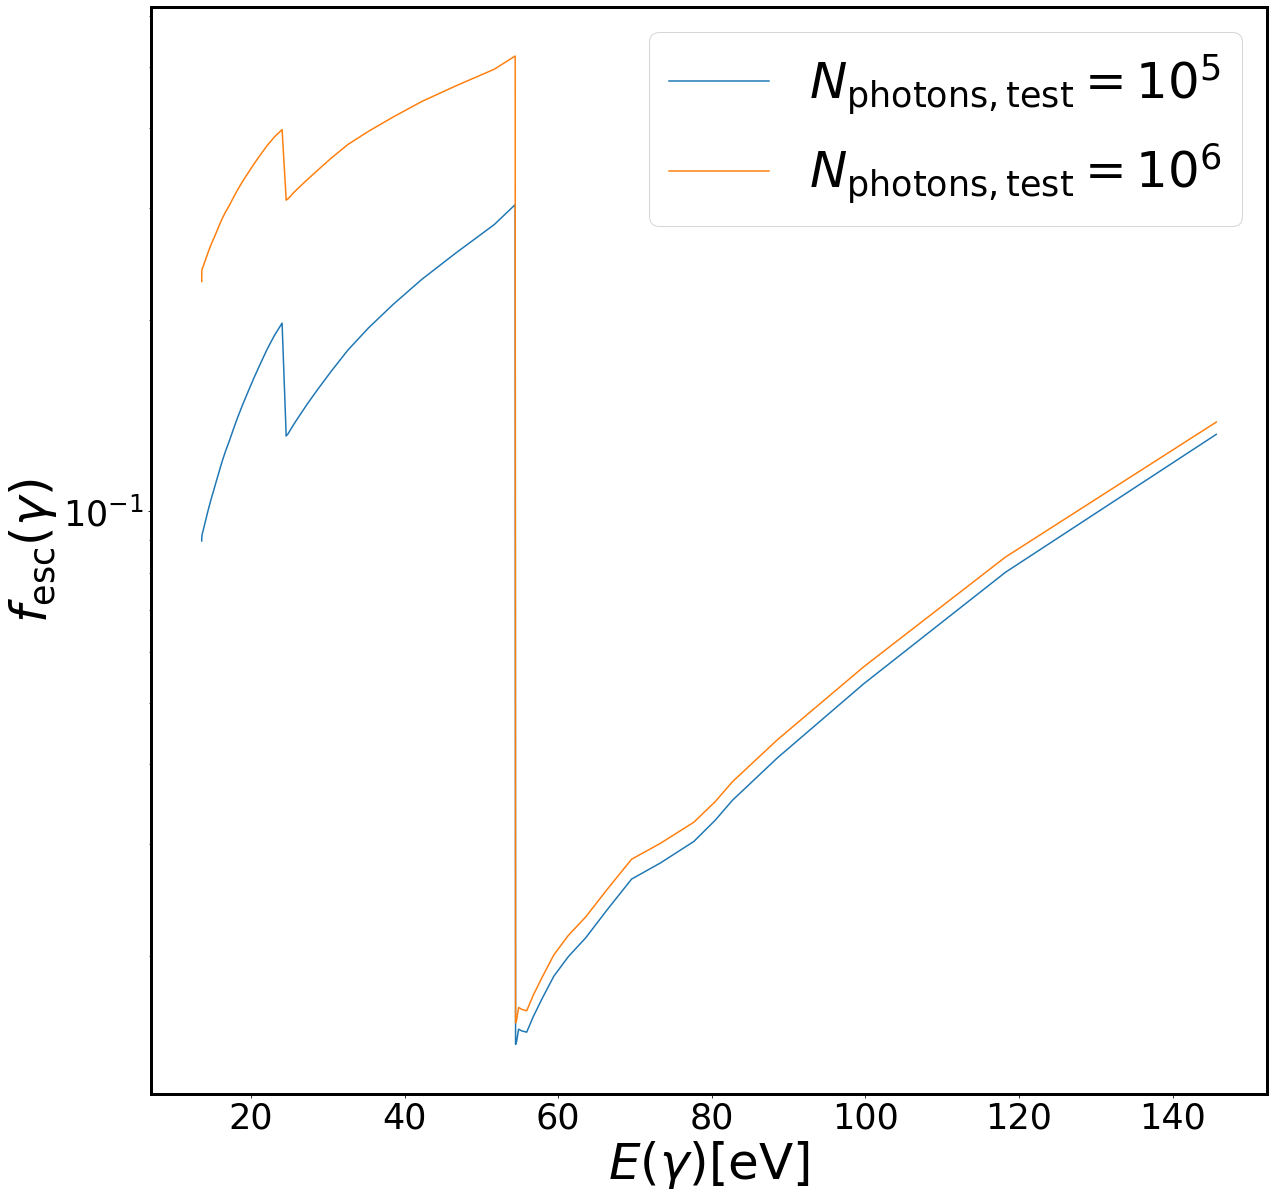

In [104]:
h_p = 6.62607004e-34
e = 1.60217662e-19

y_values_1e6 = np.zeros(len(comparison_df2.iloc[0].per_freq_1e5))
y_values_1e5 = np.zeros(len(comparison_df2.iloc[0].per_freq_1e5))
for i in range(len(comparison_df2)):
    y_values_1e6 += np.array(comparison_df2.iloc[i].per_freq_1e6)
    y_values_1e5 += np.array(comparison_df2.iloc[i].per_freq_1e5)
    
y_values_1e6/=len(comparison_df2)
y_values_1e5/=len(comparison_df2)
    
x_values = comparison_df2.iloc[0].frequencies*h_p/e
plt.plot(x_values, y_values_1e5, label='$N_\mathrm{photons, test}=10^5$')

x_values = comparison_df2.iloc[0].frequencies*h_p/e
plt.plot(x_values, y_values_1e6, label=r'$N_\mathrm{photons, test}=10^6$')
plt.ylabel(r'$f_\mathrm{esc}(\gamma)$', size=50)
plt.xlabel(r'$E(\gamma)[\mathrm{eV}]$', size=50)
plt.yscale('log')
plt.legend(fontsize=50);
#plt.ylim(0.9,100);

In [52]:
x_values = np.log10(comparison_df2.StarMass)
y_values = comparison_df2.f_esc_1e6/comparison_df2.f_esc_1e5
plt.scatter(x_values, y_values, s=300, marker='+', label='$N_\mathrm{photons, test}=10^6$')

x_values = np.log10(comparison_df3.StarMass)
y_values = comparison_df3.f_esc_5e6/comparison_df3.f_esc_1e5
plt.scatter(x_values, y_values, s=300, marker='^', label=r'$N_\mathrm{photons, test}=5 \times 10^6$')
plt.ylabel(r'$\frac{f_\mathrm{esc, test}}{f_\mathrm{esc}}$', size=50)
plt.xlabel(r'$\log(M_\mathrm{star})$', size=50)
plt.yscale('log')
plt.legend(fontsize=50)
plt.ylim(0.9,100);

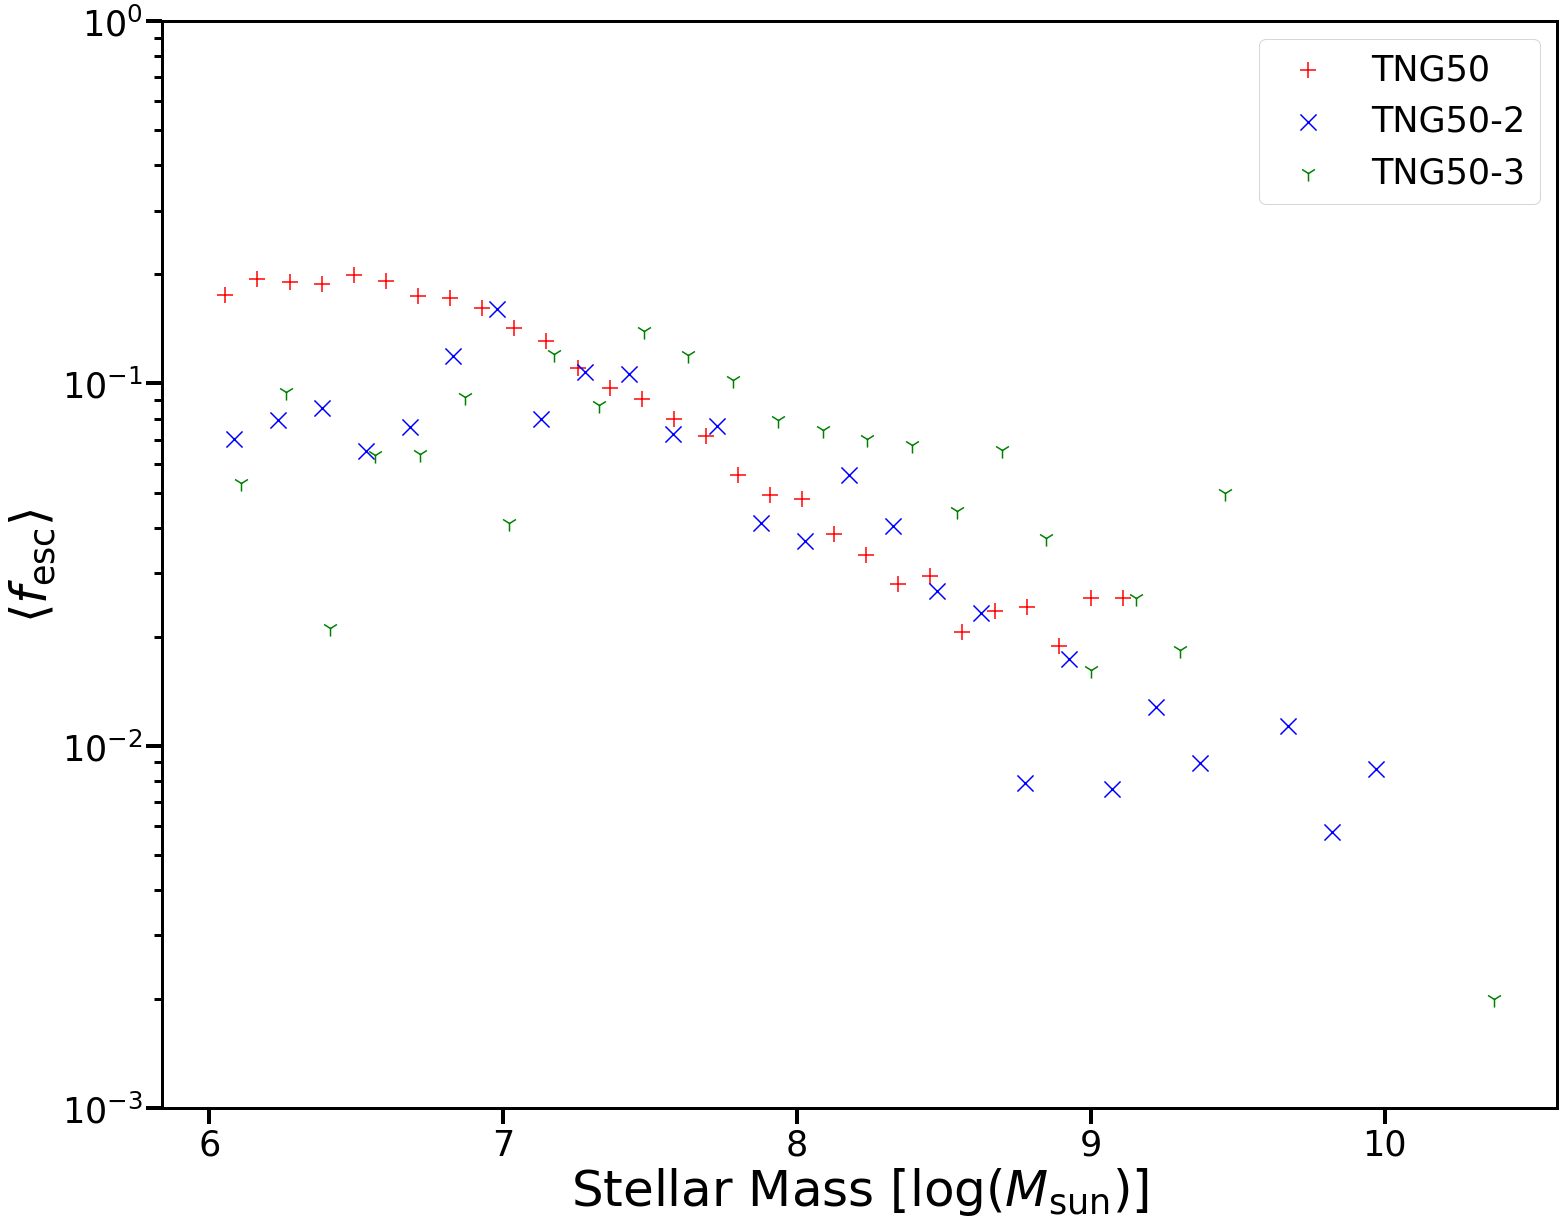

In [42]:
plot_tng_comparison(dfs, halo_prop='StarMass', bins=30, mode='mean', y_threshold=1e-3, save=True)

In [247]:
update_df(df_5e6)

In [258]:
halos_z6 = np.array(df_5e6[(df_5e6.StarMass<1e7) & (df_5e6.z==6)].ID)
halos_z8 = np.array(df_5e6[(df_5e6.StarMass<1e7) & (df_5e6.z==8)].ID)
halos_z10 = np.array(df_5e6[(df_5e6.StarMass<1e7) & (df_5e6.z==10)].ID)

array([25191,  4238, 22258, 20088, 61869, 33619, 41526, 24258,  5500,
       20279, 20915, 34017, 19512, 62846,  8727, 21424, 17206, 40553])

In [264]:
import os

In [275]:
id_dic = {10:halos_z10, 8:halos_z8, 6:halos_z6}
snap_dic = {10:'sn004', 8:'sn008', 6:'sn013'}
redshifts = [10,8,6]
numerical_tests = [6,7,8]
column_names=['x', 'y', 'z', 'a', 'Q', 'b', 'name', 'c','halo', 'd', 'packets', 'e', 'loc_uv', 'f', 'loc_x']
bin_origin = '/ptmp/mpa/mglatzle/TNG_f_esc/new_numerical_5e6/bin'
db_origin = '/ptmp/mpa/mglatzle/TNG_f_esc/new_numerical_5e6/db'

In [276]:
for packet_ex in numerical_tests:
    packets = f'1.000d+0{packet_ex}'
    setting_dir = f'/ptmp/mpa/mglatzle/TNG_f_esc/convergence_test_1e{packet_ex}'
    os.system(f'cp -r {bin_origin} {setting_dir}')
    os.system(f'cp -r {db_origin} {setting_dir}')
    for z in redshifts:
        print(f'Working on {packet_ex} and redshift {z}')
        snap = snap_dic[z]
        origin_dir = f'/ptmp/mpa/mglatzle/TNG_f_esc/new_numerical_5e6/input/L35n2160TNG/{snap}'
        input_dir = f'/ptmp/mpa/mglatzle/TNG_f_esc/convergence_test_1e{packet_ex}/input/L35n2160TNG/{snap}'
        
        selected_halos_path = os.path.join(input_dir, 'selected_halos.npy')
        halos_to_use = id_dic[z]
        np.save(selected_halos_path, halos_to_use)
        
        halo_catalog_origin = os.path.join(origin_dir, 'sel_halos_df.pickle')
        os.system(f'cp {halo_catalog_origin} {input_dir}')
        
        for halo in halos_to_use:
            print(f'Working on halo {halo}')
            halo_origin = os.path.join(origin_dir, f'g{halo}')
            os.system(f'cp -r {halo_origin} {input_dir}')
            
            halo_dest = os.path.join(input_dir, f'g{halo}')
            sources_path = os.path.join(halo_dest, 'sources_ic00.in')
            sources = pd.read_table(sources_path, delimiter='\t', names=column_names)
            sources.packets = packets
            sources.to_csv(sources_path, sep='\t', header=False, index=False)

0

0

Working on 6 and redshift 10


0

Working on halo 7348


0

Working on halo 6053


0

Working on halo 758


0

Working on halo 825


0

Working on halo 872


0

Working on halo 2048


0

Working on halo 3995


0

Working on halo 2184


0

Working on halo 2302


0

Working on halo 611


0

Working on halo 3854


0

Working on halo 1415


0

Working on halo 4276


0

Working on 6 and redshift 8


0

Working on halo 4679


0

Working on halo 2634


0

Working on halo 5604


0

Working on halo 2149


0

Working on halo 2226


0

Working on halo 16090


0

Working on halo 4994


0

Working on halo 2268


0

Working on halo 17656


0

Working on halo 2310


0

Working on halo 3203


0

Working on halo 10638


0

Working on halo 7984


0

Working on halo 5970


0

Working on halo 3837


0

Working on halo 1940


0

Working on halo 1201


0

Working on halo 2397


0

Working on halo 12909


0

Working on 6 and redshift 6


0

Working on halo 25191


0

Working on halo 4238


0

Working on halo 22258


0

Working on halo 20088


0

Working on halo 61869


0

Working on halo 33619


0

Working on halo 41526


0

Working on halo 24258


0

Working on halo 5500


0

Working on halo 20279


0

Working on halo 20915


0

Working on halo 34017


0

Working on halo 19512


0

Working on halo 62846


0

Working on halo 8727


0

Working on halo 21424


0

Working on halo 17206


0

Working on halo 40553


0

0

0

Working on 7 and redshift 10


0

Working on halo 7348


0

Working on halo 6053


0

Working on halo 758


0

Working on halo 825


0

Working on halo 872


0

Working on halo 2048


0

Working on halo 3995


0

Working on halo 2184


0

Working on halo 2302


0

Working on halo 611


0

Working on halo 3854


0

Working on halo 1415


0

Working on halo 4276


0

Working on 7 and redshift 8


0

Working on halo 4679


0

Working on halo 2634


0

Working on halo 5604


0

Working on halo 2149


0

Working on halo 2226


0

Working on halo 16090


0

Working on halo 4994


0

Working on halo 2268


0

Working on halo 17656


0

Working on halo 2310


0

Working on halo 3203


0

Working on halo 10638


0

Working on halo 7984


0

Working on halo 5970


0

Working on halo 3837


0

Working on halo 1940


0

Working on halo 1201


0

Working on halo 2397


0

Working on halo 12909


0

Working on 7 and redshift 6


0

Working on halo 25191


0

Working on halo 4238


0

Working on halo 22258


0

Working on halo 20088


0

Working on halo 61869


0

Working on halo 33619


0

Working on halo 41526


0

Working on halo 24258


0

Working on halo 5500


0

Working on halo 20279


0

Working on halo 20915


0

Working on halo 34017


0

Working on halo 19512


0

Working on halo 62846


0

Working on halo 8727


0

Working on halo 21424


0

Working on halo 17206


0

Working on halo 40553


0

0

0

Working on 8 and redshift 10


0

Working on halo 7348


0

Working on halo 6053


0

Working on halo 758


0

Working on halo 825


0

Working on halo 872


0

Working on halo 2048


0

Working on halo 3995


0

Working on halo 2184


0

Working on halo 2302


0

Working on halo 611


0

Working on halo 3854


0

Working on halo 1415


0

Working on halo 4276


0

Working on 8 and redshift 8


0

Working on halo 4679


0

Working on halo 2634


0

Working on halo 5604


0

Working on halo 2149


0

Working on halo 2226


0

Working on halo 16090


0

Working on halo 4994


0

Working on halo 2268


0

Working on halo 17656


0

Working on halo 2310


0

Working on halo 3203


0

Working on halo 10638


0

Working on halo 7984


0

Working on halo 5970


0

Working on halo 3837


0

Working on halo 1940


0

Working on halo 1201


0

Working on halo 2397


0

Working on halo 12909


0

Working on 8 and redshift 6


0

Working on halo 25191


0

Working on halo 4238


0

Working on halo 22258


0

Working on halo 20088


0

Working on halo 61869


0

Working on halo 33619


0

Working on halo 41526


0

Working on halo 24258


0

Working on halo 5500


0

Working on halo 20279


0

Working on halo 20915


0

Working on halo 34017


0

Working on halo 19512


0

Working on halo 62846


0

Working on halo 8727


0

Working on halo 21424


0

Working on halo 17206


0

Working on halo 40553


0

In [2]:
import os
import fileinput
import sys

In [29]:
run_dir_in= '/ptmp/mpa/mglatzle/TNG_f_esc/new_main/run/L35n2160TNG'
run_dir_out= '/ptmp/mpa/mglatzle/TNG_f_esc/esc_analysis/run/L35n2160TNG'
#all_source_dir = '/ptmp/mpa/mglatzle/TNG_f_esc/all_sources/input/L35n2160TNG'
snap_dirs = ['sn013', 'sn008', 'sn004']

In [58]:
for snap in snap_dirs:
    snap_dir = os.path.join(run_dir_out, snap)
    for halo in os.listdir(snap_dir):
        halo_dir = os.path.join(snap_dir, halo)
        
        input_dir = os.path.join(halo_dir, 'Input')
        
        origin_input = f'/freya/ptmp/mpa/mglatzle/TNG_f_esc/esc_analysis/input/L35n2160TNG/{snap}/{halo}'
        dens_in = os.path.join(origin_input, 'dens_ic00.in')
        dens_to = os.path.join(input_dir, 'dens_ic00.in')
        
        dust_in = os.path.join(origin_input, 'dust')
        dust_to = os.path.join(input_dir, 'dust')
        os.system(f'ln -sfn {dust_in} {dust_to}')
        
        ion_in = os.path.join(origin_input, 'ion.in')
        ion_to = os.path.join(input_dir, 'ion.in')
        os.system(f'ln -sfn {ion_in} {ion_to}')
        
        simul_in = os.path.join(origin_input, 'simul_ic00.in')
        simul_to = os.path.join(input_dir, 'simul_ic00.in')
        os.system(f'ln -sfn {simul_in} {simul_to}')
        
        sources_in = os.path.join(origin_input, 'sources_ic00.in')
        sources_to = os.path.join(input_dir, 'sources_ic00.in')
        os.system(f'ln -sfn {sources_in} {sources_to}')
        
        temp_in = os.path.join(origin_input, 'temp_ic00.in')
        temp_to = os.path.join(input_dir, 'temp_ic00.in')
        os.system(f'ln -sfn {temp_in} {temp_to}')

In [57]:
origin_input = f'/freya/ptmp/mpa/mglatzle/TNG_f_esc/esc_analysis/input/L35n2160TNG/sn004/g4265'
input_dir = f'/freya/ptmp/mpa/mglatzle/TNG_f_esc/esc_analysis/run/L35n2160TNG/sn004/g4265/Input'
dens_in = os.path.join(origin_input, 'dens_ic00.in')
dens_to = os.path.join(input_dir, 'dens_ic00.in')

dust_in = os.path.join(origin_input, 'dust')
dust_to = os.path.join(input_dir, 'dust')
os.system(f'ln -sfn {dust_in} {dust_to}')

ion_in = os.path.join(origin_input, 'ion.in')
ion_to = os.path.join(input_dir, 'ion.in')
os.system(f'ln -sfn {ion_in} {ion_to}')

simul_in = os.path.join(origin_input, 'simul_ic00.in')
simul_to = os.path.join(input_dir, 'simul_ic00.in')
os.system(f'ln -sfn {simul_in} {simul_to}')

sources_in = os.path.join(origin_input, 'sources_ic00.in')
sources_to = os.path.join(input_dir, 'sources_ic00.in')
os.system(f'ln -sfn {sources_in} {sources_to}')

temp_in = os.path.join(origin_input, 'temp_ic00.in')
temp_to = os.path.join(input_dir, 'temp_ic00.in')
os.system(f'ln -sfn {temp_in} {temp_to}')

0

In [41]:
for snap in snap_dirs:
    snap_dir_in = os.path.join(run_dir_in, snap)
    snap_dir_out = os.path.join(run_dir_out, snap)
    for halo in os.listdir(snap_dir_in):
        halo_dir_in = os.path.join(snap_dir_in, halo)
        halo_dir_out = os.path.join(snap_dir_out, halo)
        
        output_dir_in = os.path.join(halo_dir_in, 'Output')
        output_dir_out = os.path.join(halo_dir_out, 'Output')
        
        config_dir_in = os.path.join(halo_dir_in, 'config')
        config_dir_out = os.path.join(halo_dir_out, 'config')
        
        last_rt_in = os.path.join(output_dir_in, 'phys_ic00_rt05.out')
        init_in = os.path.join(halo_dir_in, 'SYS_INIT.in')
        if os.path.isfile(last_rt_in):
            print(f'working on halo {halo} in snap {snap}')
            #os.system(f'cp -r {halo_dir_in} {snap_dir_out}')
#             os.system(f'mkdir {halo_dir_out}')
#             os.system(f'mkdir {output_dir_out}')
#             os.system(f'cp {last_rt_in} {output_dir_out}')
#             os.system(f'cp -r {config_dir_in} {halo_dir_out}')
#             os.system(f'cp -r {init_in} {halo_dir_out}')
            try:
                simul_file = os.path.join(config_dir_out, 'SIMULATION.in')
                for line in fileinput.input(simul_file, inplace=1):
                    if (line[:8] == "'IN_DIR=") or (line[:9] == "'OUT_DIR="):
                        line = line.replace('new_main','esc_analysis')
                    sys.stdout.write(line)
            except:
                print(halo_dir_in)
                continue
fileinput.close()

working on halo g36099 in snap sn013
working on halo g41356 in snap sn013
working on halo g24614 in snap sn013
working on halo g22417 in snap sn013
working on halo g35962 in snap sn013
working on halo g30150 in snap sn013
working on halo g5899 in snap sn013
working on halo g20270 in snap sn013
working on halo g4221 in snap sn013
working on halo g37983 in snap sn013
working on halo g18882 in snap sn013
working on halo g8898 in snap sn013
working on halo g54973 in snap sn013
working on halo g12459 in snap sn013
working on halo g36847 in snap sn013
working on halo g20888 in snap sn013
working on halo g4690 in snap sn013
working on halo g51502 in snap sn013
working on halo g17369 in snap sn013
working on halo g15385 in snap sn013
working on halo g33050 in snap sn013
working on halo g10977 in snap sn013
working on halo g13255 in snap sn013
working on halo g83289 in snap sn013
working on halo g25747 in snap sn013
working on halo g31842 in snap sn013
working on halo g19627 in snap sn013
worki

working on halo g5347 in snap sn013
working on halo g28314 in snap sn013
working on halo g22258 in snap sn013
working on halo g24657 in snap sn013
working on halo g43408 in snap sn013
working on halo g9135 in snap sn013
working on halo g20230 in snap sn013
working on halo g41700 in snap sn013
working on halo g19142 in snap sn013
working on halo g81400 in snap sn013
working on halo g24824 in snap sn013
working on halo g5835 in snap sn013
working on halo g22521 in snap sn013
working on halo g15146 in snap sn013
working on halo g22582 in snap sn013
working on halo g34697 in snap sn013
working on halo g16750 in snap sn013
working on halo g35740 in snap sn013
working on halo g13666 in snap sn013
working on halo g1386 in snap sn013
working on halo g15303 in snap sn013
working on halo g9742 in snap sn013
working on halo g12761 in snap sn013
working on halo g26225 in snap sn013
working on halo g37561 in snap sn013
working on halo g14737 in snap sn013
working on halo g9288 in snap sn013
working

working on halo g35497 in snap sn013
working on halo g7619 in snap sn013
working on halo g11620 in snap sn013
working on halo g25153 in snap sn013
working on halo g27001 in snap sn013
working on halo g20137 in snap sn013
working on halo g5534 in snap sn013
working on halo g7680 in snap sn013
working on halo g30770 in snap sn013
working on halo g46502 in snap sn013
working on halo g11957 in snap sn013
working on halo g16545 in snap sn013
working on halo g27337 in snap sn013
working on halo g6110 in snap sn013
working on halo g15493 in snap sn013
working on halo g75691 in snap sn013
working on halo g19547 in snap sn013
working on halo g35651 in snap sn013
working on halo g30471 in snap sn013
working on halo g17931 in snap sn013
working on halo g28902 in snap sn013
working on halo g22344 in snap sn013
working on halo g13672 in snap sn013
working on halo g34305 in snap sn013
working on halo g26035 in snap sn013
working on halo g22393 in snap sn013
working on halo g11048 in snap sn013
worki

working on halo g17526 in snap sn013
working on halo g9780 in snap sn013
working on halo g34250 in snap sn013
working on halo g38309 in snap sn013
working on halo g46705 in snap sn013
working on halo g24730 in snap sn013
working on halo g37810 in snap sn013
working on halo g38088 in snap sn013
working on halo g15984 in snap sn013
working on halo g20475 in snap sn013
working on halo g24054 in snap sn013
working on halo g29462 in snap sn013
working on halo g23830 in snap sn013
working on halo g32157 in snap sn013
working on halo g11533 in snap sn013
working on halo g10294 in snap sn013
working on halo g22379 in snap sn013
working on halo g11214 in snap sn013
working on halo g18486 in snap sn013
working on halo g88517 in snap sn013
working on halo g22102 in snap sn013
working on halo g33340 in snap sn013
working on halo g38355 in snap sn013
working on halo g1279 in snap sn013
working on halo g63890 in snap sn013
working on halo g27145 in snap sn013
working on halo g11117 in snap sn013
wor

working on halo g28349 in snap sn008
working on halo g1778 in snap sn008
working on halo g15388 in snap sn008
working on halo g8737 in snap sn008
working on halo g16876 in snap sn008
working on halo g3194 in snap sn008
working on halo g15723 in snap sn008
working on halo g5255 in snap sn008
working on halo g7778 in snap sn008
working on halo g2191 in snap sn008
working on halo g6046 in snap sn008
working on halo g8188 in snap sn008
working on halo g5536 in snap sn008
working on halo g1620 in snap sn008
working on halo g1461 in snap sn008
working on halo g24177 in snap sn008
working on halo g25453 in snap sn008
working on halo g10663 in snap sn008
working on halo g21400 in snap sn008
working on halo g2369 in snap sn008
working on halo g19097 in snap sn008
working on halo g9243 in snap sn008
working on halo g45887 in snap sn008
working on halo g4323 in snap sn008
working on halo g7752 in snap sn008
working on halo g5917 in snap sn008
working on halo g7958 in snap sn008
working on halo g9

working on halo g39611 in snap sn008
working on halo g3256 in snap sn008
working on halo g19464 in snap sn008
working on halo g8983 in snap sn008
working on halo g10366 in snap sn008
working on halo g27737 in snap sn008
working on halo g23599 in snap sn008
working on halo g2898 in snap sn008
working on halo g5468 in snap sn008
working on halo g8886 in snap sn008
working on halo g2141 in snap sn008
working on halo g8500 in snap sn008
working on halo g9267 in snap sn008
working on halo g9632 in snap sn008
working on halo g3964 in snap sn008
working on halo g16840 in snap sn008
working on halo g12508 in snap sn008
working on halo g2626 in snap sn008
working on halo g12721 in snap sn008
working on halo g13014 in snap sn008
working on halo g24484 in snap sn008
working on halo g2664 in snap sn008
working on halo g11210 in snap sn008
working on halo g3814 in snap sn008
working on halo g9823 in snap sn008
working on halo g16225 in snap sn008
working on halo g8281 in snap sn008
working on halo 

working on halo g8176 in snap sn008
working on halo g23560 in snap sn008
working on halo g15794 in snap sn008
working on halo g24447 in snap sn008
working on halo g47415 in snap sn008
working on halo g3228 in snap sn008
working on halo g13888 in snap sn008
working on halo g3213 in snap sn008
working on halo g1068 in snap sn008
working on halo g13619 in snap sn008
working on halo g3650 in snap sn008
working on halo g13948 in snap sn008
working on halo g5292 in snap sn008
working on halo g15292 in snap sn008
working on halo g22497 in snap sn008
working on halo g6875 in snap sn008
working on halo g7180 in snap sn008
working on halo g14445 in snap sn008
working on halo g12277 in snap sn008
working on halo g10440 in snap sn008
working on halo g9073 in snap sn008
working on halo g25753 in snap sn008
working on halo g6735 in snap sn008
working on halo g4153 in snap sn008
working on halo g7523 in snap sn008
working on halo g7378 in snap sn008
working on halo g16540 in snap sn008
working on hal

working on halo g5554 in snap sn008
working on halo g18075 in snap sn008
working on halo g4133 in snap sn008
working on halo g6006 in snap sn008
working on halo g7367 in snap sn008
working on halo g30760 in snap sn008
working on halo g14908 in snap sn008
working on halo g1137 in snap sn008
working on halo g10472 in snap sn008
working on halo g23593 in snap sn008
working on halo g3599 in snap sn008
working on halo g9515 in snap sn008
working on halo g9755 in snap sn008
working on halo g38887 in snap sn008
working on halo g13495 in snap sn008
working on halo g17005 in snap sn008
working on halo g17593 in snap sn008
working on halo g19345 in snap sn008
working on halo g26091 in snap sn008
working on halo g6211 in snap sn008
working on halo g8025 in snap sn008
working on halo g4727 in snap sn008
working on halo g4117 in snap sn008
working on halo g10667 in snap sn008
working on halo g5624 in snap sn008
working on halo g2942 in snap sn008
working on halo g2570 in snap sn008
working on halo 

working on halo g3815 in snap sn004
working on halo g864 in snap sn004
working on halo g4433 in snap sn004
working on halo g5053 in snap sn004
working on halo g638 in snap sn004
working on halo g12630 in snap sn004
working on halo g3392 in snap sn004
working on halo g1383 in snap sn004
working on halo g685 in snap sn004
working on halo g2536 in snap sn004
working on halo g6419 in snap sn004
working on halo g2008 in snap sn004
working on halo g2207 in snap sn004
working on halo g11325 in snap sn004
working on halo g1333 in snap sn004
working on halo g3748 in snap sn004
working on halo g930 in snap sn004
working on halo g9361 in snap sn004
working on halo g1249 in snap sn004
working on halo g2637 in snap sn004
working on halo g1501 in snap sn004
working on halo g6395 in snap sn004
working on halo g31640 in snap sn004
working on halo g2334 in snap sn004
working on halo g2273 in snap sn004
working on halo g751 in snap sn004
working on halo g6015 in snap sn004
working on halo g5072 in snap 

working on halo g2913 in snap sn004
working on halo g3068 in snap sn004
working on halo g29 in snap sn004
working on halo g14267 in snap sn004
working on halo g16828 in snap sn004
working on halo g4740 in snap sn004
working on halo g3990 in snap sn004
working on halo g5641 in snap sn004
working on halo g8555 in snap sn004
working on halo g1961 in snap sn004
working on halo g1907 in snap sn004
working on halo g16226 in snap sn004
working on halo g561 in snap sn004
working on halo g3665 in snap sn004
working on halo g2844 in snap sn004
working on halo g6626 in snap sn004
working on halo g1313 in snap sn004
working on halo g2420 in snap sn004
working on halo g6169 in snap sn004
working on halo g1805 in snap sn004
working on halo g4664 in snap sn004
working on halo g941 in snap sn004
working on halo g2232 in snap sn004
working on halo g5248 in snap sn004
working on halo g4320 in snap sn004
working on halo g6621 in snap sn004
working on halo g7248 in snap sn004
working on halo g14533 in sna

working on halo g7400 in snap sn004
working on halo g967 in snap sn004
working on halo g4053 in snap sn004
working on halo g1993 in snap sn004
working on halo g2007 in snap sn004
working on halo g10383 in snap sn004
working on halo g4252 in snap sn004
working on halo g14130 in snap sn004
working on halo g1324 in snap sn004
working on halo g927 in snap sn004
working on halo g5864 in snap sn004
working on halo g6336 in snap sn004
working on halo g3493 in snap sn004
working on halo g4003 in snap sn004
working on halo g2430 in snap sn004
working on halo g1680 in snap sn004
working on halo g2528 in snap sn004
working on halo g4330 in snap sn004
working on halo g427 in snap sn004
working on halo g8141 in snap sn004
working on halo g6114 in snap sn004
working on halo g2867 in snap sn004
working on halo g7365 in snap sn004
working on halo g847 in snap sn004
working on halo g1786 in snap sn004
working on halo g1121 in snap sn004
working on halo g5719 in snap sn004
working on halo g807 in snap s

working on halo g2054 in snap sn004
working on halo g326 in snap sn004
working on halo g972 in snap sn004
working on halo g2627 in snap sn004
working on halo g786 in snap sn004
working on halo g2017 in snap sn004
working on halo g1688 in snap sn004
working on halo g1306 in snap sn004
working on halo g4371 in snap sn004
working on halo g2291 in snap sn004
working on halo g746 in snap sn004
working on halo g4098 in snap sn004
working on halo g2820 in snap sn004
working on halo g1627 in snap sn004
working on halo g8636 in snap sn004
working on halo g47646 in snap sn004
working on halo g6625 in snap sn004
working on halo g6428 in snap sn004
working on halo g1199 in snap sn004
working on halo g1698 in snap sn004
working on halo g3132 in snap sn004
working on halo g4094 in snap sn004
working on halo g2877 in snap sn004
working on halo g3087 in snap sn004
working on halo g3555 in snap sn004
working on halo g6149 in snap sn004
working on halo g2394 in snap sn004
working on halo g1868 in snap s

In [2]:
from crashpy.dataclasses.simulation import LoadedSimulation as Sim

In [8]:
simpath = '/freya/ptmp/mpa/mglatzle/TNG_f_esc/esc_analysis/run/L35n2160TNG/sn008/g8154'
sim = Sim(simpath)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa1 in position 1: invalid start byte

In [33]:
fesc_file = '/ptmp/mpa/mglatzle/TNG_f_esc/esc_analysis/00_f_esc.txt'
for line in fileinput.input(fesc_file, inplace=1):
    line = line.replace('new_main','esc_analysis')
    sys.stdout.write(line)
fileinput.close()

In [21]:
counter = 0
for snap in snap_dirs:
    snap_dir_in = os.path.join(run_dir_in, snap)
    snap_dir_out = os.path.join(run_dir_out, snap)
    for halo in os.listdir(snap_dir):
        halo_dir_in = os.path.join(snap_dir_in, halo)
        halo_dir_out = os.path.join(snap_dir_out, halo)
        
        output_dir = os.path.join(halo_dir_in, 'Output')

        
        last_rt = os.path.join(output_dir, 'phys_ic00_rt05.out')
        if os.path.isfile(last_rt):
            counter += 1
print(counter)
print(tot_counter)

1229
10652


In [ ]:
for snap in snap_dirs:
    snap_dir = os.path.join(input_dir, snap)
    snap_dir_sources = os.path.join(all_source_dir, snap)
    counter=1
    for halo in os.listdir(snap_dir):
        halo_dir = os.path.join(snap_dir, halo)
        halo_dir_sources = os.path.join(snap_dir_sources, halo)
        
        source_file = os.path.join(input_dir, 'sources_ic00.in')
        source_file_sources = os.path.join(input_dir_sources, 'sources_ic00.in')
        
        os.system(f'rm {source_file}')
        os.system(f'cp {source_file_sources} {input_dir}')

In [ ]:
for snap in snap_dirs:
    snap_dir = os.path.join(run_dir, snap)
    for halo in os.listdir(snap_dir):
        halo_dir = os.path.join(snap_dir, halo)
        config_dir = os.path.join(halo_dir, 'config')
        simul_file = os.path.join(config_dir, 'SIMULATION.in')
        for line in fileinput.input(simul_file, inplace=1):
            if (line[:8] == "'IN_DIR=") or (line[:9] == "'OUT_DIR="):
                line = line.replace('conv1e8','escape_test')
            sys.stdout.write(line)
fileinput.close()

In [222]:
from crashpy.dataclasses.simulation import LoadedSimulation as Sim

In [244]:
for snap in snap_dirs:
    snap_dir = os.path.join(run_dir, snap)
    for halo in os.listdir(snap_dir):
        halo_dir = os.path.join(snap_dir, halo)
        sim = Sim(halo_dir)
        ic = sim.ICs['00']
        try: 
            a = ic.simulation.info['config']['SIMULATION']['IS_COSMOEVOLUTION_ENABLED']
        except:
            print(halo_dir)

/ptmp/mpa/mglatzle/TNG_f_esc/escape_test/run/L35n2160TNG/sn008/g4679
/ptmp/mpa/mglatzle/TNG_f_esc/escape_test/run/L35n2160TNG/sn004/g7348


In [239]:
sim = Sim('/ptmp/mpa/mglatzle/TNG_f_esc/escape_test/run/L35n2160TNG/sn013/g3090')

In [240]:
ic = sim.ICs['00']

In [241]:
ic.sources

,i,j,k,em,spec_name,spec_type,N_p,fescUV,fescX,spec_file
0,52,52,52,0.000022,'110175595250_r65','L35n2160TNG/sn013/g3090',100000000.0,1.0,1.0,/freya/ptmp/mpa/mglatzle/TNG_f_esc/conv1e8/db/...
1,52,52,52,0.000002,'109311408681_r65','L35n2160TNG/sn013/g3090',100000000.0,1.0,1.0,/freya/ptmp/mpa/mglatzle/TNG_f_esc/conv1e8/db/...
2,52,52,54,0.000087,'110149861284_r65','L35n2160TNG/sn013/g3090',100000000.0,1.0,1.0,/freya/ptmp/mpa/mglatzle/TNG_f_esc/conv1e8/db/...
3,53,52,52,0.000001,'109311042089_r65','L35n2160TNG/sn013/g3090',100000000.0,1.0,1.0,/freya/ptmp/mpa/mglatzle/TNG_f_esc/conv1e8/db/...
4,53,52,53,0.000369,'110890553140_r65','L35n2160TNG/sn013/g3090',100000000.0,1.0,1.0,/freya/ptmp/mpa/mglatzle/TNG_f_esc/conv1e8/db/...
...,...,...,...,...,...,...,...,...,...,...
154,98,77,49,0.000218,'111010981191_r65','L35n2160TNG/sn013/g3090',100000000.0,1.0,1.0,/freya/ptmp/mpa/mglatzle/TNG_f_esc/conv1e8/db/...
155,99,96,46,0.000011,'109323887401_r65','L35n2160TNG/sn013/g3090',100000000.0,1.0,1.0,/freya/ptmp/mpa/mglatzle/TNG_f_esc/conv1e8/db/...
156,38,82,33,0.000005,'109310572329_r65','L35n2160TNG/sn013/g3090',100000000.0,1.0,1.0,/freya/ptmp/mpa/mglatzle/TNG_f_esc/conv1e8/db/...
157,37,84,35,0.000004,'109310649897_r65','L35n2160TNG/sn013/g3090',100000000.0,1.0,1.0,/freya/ptmp/mpa/mglatzle/TNG_f_esc/conv1e8/db/...


In [242]:
ic.simulation.info['config']['SIMULATION']['IS_COSMOEVOLUTION_ENABLED']

'FALSE'